In [114]:
import time
from datetime import datetime
import pickle
import numpy as np
import pandas as pd


from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.ar_model import AutoReg

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

import pmdarima as pm
from arch import arch_model

from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import StackingRegressor

import requests
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

---

## <span style="font-family: cursive;">Прогноз цен на металлы.</span>

![Intro](data/intro.jpg)

---

## Описание проекта:
Основная задача:

- Создать модель, прогнозирующую спотовую цену на металл (в нашем случае медь) с горизонтом планирования 3 месяца. Затем аггрегировать показатели по месяцу, выводя среднюю цену периода плюс границы доверительного интервала для прогноза.

- Воссоздать модель в компактном и мобильном виде, как базовый инструмент для более глубокого анализа рынков металлов. С высокой степенью устойчивости в контексте источников данных, что продиктованно необходимостью ежедневного уточнения прогноза.

- Со звездочкой. Задеплоить микросервис на рабочий сервер, но есть нюанс, что этот момент скорее всего будет выполнен в виде подтверждения исполнения, т.к. ели будет приянто решение использовать в реальной работе, то автоматом попадет под внутреннюю разработку нынешней компании и комерческую тайну.

Выбор метрики:

- Для прогнозирования возьмем в расчет ориентир на MAE, RMSE и MAPE. С концентрацией на MAE.

- RMSE измеряет среднеквадратичное отклонение между прогнозируемыми значениями и фактическими значениями. Она более чувствительна к большим ошибкам, так как она берет квадрат каждой ошибки. RMSE также имеет ту же размерность, что и исходные данные, что может быть полезно для интерпретации результатов.

- MAE, с другой стороны, измеряет среднюю абсолютную ошибку между прогнозируемыми значениями и фактическими значениями. Она не учитывает направление ошибки и может быть полезна, когда все ошибки равнозначны, что для нас является ключевым фактором при прогнозе средних значений.

- Пороговым значением MAE примем 150-200$.

Описание датасета:

- Датасет парсится с сайта westmetall, который в свою очередь аггрегирует информацию с Лондонской биржи металлов (LME).

- Избан единственный источник данных в следствие необходимости создания бенчмарка для LME высокой степени устойчивости, что с одной стороны понижает точность прогноза (наиболее вероятно), но с другой обеспечивает надежность. 

- В данном исследовании приводится анализ единственного металла, но парсер пополняет базу данных для всех ключевых non-ferrous metalls. Данные не имеют как таковых выбросов, т.к. формируются на основании временных рядов цен и запасов металлов, отражая реальную коньюктуру рынка, но могут содержаться аномалии.

P.S. Для упрощения анализа других металлов максимально унифицировал шаблон действий. В соседних файлах будет аналитика по аллюминию, цинку, свинцу, никелю.

---

### Технический блок.

### Содержание:
- Без парсера, берем данные из базы.
- Функции для использования в исследовании

---

- Работа будет проводиться с датасетом по меди, но в будущем, в случае подтверждения основных тезисов работоспособности модели, планируется внедрение данного алгоритма для формирования легковесного бенчмарка для группы металлов.

In [115]:
# Функция для проверки ряда на стационарность и вывода графиков автокорреляции полной и частичной
def stationary_test(data, name='заглушка', crit_value='5%', graph='yes', figsize=(7, 9)):
    if graph == 'yes':
        # Графики автокорреляции полной и частичной
        fig, axes = plt.subplots(2, 1, figsize=figsize)
        plot_acf(data, ax=axes[0], title=f'Автокорреляция {name}')
        plot_pacf(data, ax=axes[1], title=f'Частичная автокорреляция {name}')
    else:
        pass

    # Тест на стационарность
    test = adfuller(data)
    p_value = test[0]
    crit_value = test[4][crit_value]
    if p_value > crit_value:
        print('Есть единичные корни, ряд не стационарен')
        print({'p_value': p_value, 'crit_value (5%)': crit_value})
    else:
        print('Единичных корней нет, ряд стационарен')
        print({'p_value': p_value, 'crit_value (5%)': crit_value})

In [116]:
# Функция для расчета RMSE, MAE и MAPE
def metrics_calculation(test_df, pred_df, name='заглушка'):
    # Переменная для логирования даты эксперимента
    date_of_experiment = pd.to_datetime(datetime.today().date())

    print(
        f'RMSE для {name}: {(rmse := np.sqrt(mean_squared_error(test_df, pred_df)).round(3))}')

    # По MAE
    print(
        f'MAE для {name}: {(mae := mean_absolute_error(test_df, pred_df).round(3))}')

    # По MAPE
    print(
        f'MAPE для {name}: {(mape := mean_absolute_percentage_error(test_df, pred_df).round(3)*100)}%')

    print('\n')
    result_row = f'\n{date_of_experiment},{name},{rmse},{mae},{mape}'

    return result_row

In [117]:
# Функция для логирования метрик
def log_metrics_stock(metric):
    with open('./data/errors/stock_nickel.csv', 'r') as file:
        file_content = file.read()
        if metric in file_content:
            print("Дубликат значения metric. Не сохраняем.")
        else:
            # Сохраняем значение metric_stock в файл
            with open('./data/errors/stock_nickel.csv', 'a') as file:
                file.write(metric)


def log_metrics_spot(metric):
    with open('./data/errors/spot_nickel.csv', 'r') as file:
        file_content = file.read()
        if metric in file_content:
            print("Дубликат значения metric. Не сохраняем.")
        else:
            # Сохраняем значение metric_stock в файл
            with open('./data/errors/spot_nickel.csv', 'a') as file:
                file.write(metric)

In [118]:
# Функция для построения графиков
def visualisation_prog(pred_df, forecast_df, train_df, test_df, name=''):
    plt.plot(pred_df, label='Prediction')
    plt.plot(forecast_df, linestyle='--', label='Confidence Interval')
    plt.plot(train_df, label='Training Data')
    plt.plot(test_df, label='Test Data')
    plt.title(f'Прогноз для {name}')
    plt.legend()
    plt.show()

In [119]:
# Функция для кодирования даты
def date_format_reverse(date):
    date = datetime.strptime(
        str(date),
        "%Y-%m-%d %H:%M:%S").timestamp()*1000
    return int(date)

---

### Часть 0.

- Предподготовка данных, первичный анализ и формирование датафреймов для последующих этапов.

In [120]:
# Блок предподготовки полученных данных
# Обработка данных полученных с lme
data = pd.read_csv('./data/nickel.csv',
                parse_dates=['date'], index_col=['date'])

,LME Nickel Cash-Settlement,LME Nickel 3-month,LME Nickel stock
count,3981.000000,3981.000000,3981.000000
mean,16724.116554,16114.233610,203.861107
std,5485.864411,5729.578165,126.121964
min,0.000000,0.000000,0.000000
25%,12490.000000,12230.000000,103.278000
50%,16070.000000,15790.000000,166.188000
75%,19960.000000,19510.000000,296.898000
max,42995.000000,42200.000000,470.376000


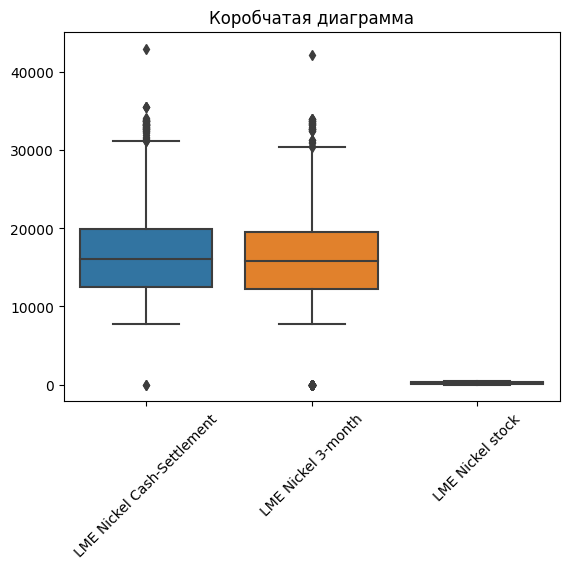

In [121]:
# В данном случае понятие выброса отсуствует, т.к. датасет составлен из
# реальных финансовых данных, следовательно мы должны выявить аномалии,
# конкретно здесь это нулевые значения в изначальном, неинтрерполированном
# датасете.

box = sns.boxplot(data=data)
box.set_title('Коробчатая диаграмма')
box.set_xticklabels(box.get_xticklabels(), rotation=45)

data.describe()

> Мы обнаружили аномалию - пропуск в данных

,LME Nickel Cash-Settlement,LME Nickel 3-month,LME Nickel stock
count,3884.000000,3884.000000,3884.000000
mean,16452.351442,16514.329042,207.501517
std,5201.791831,5201.495661,125.373656
min,7710.000000,7750.000000,0.026000
25%,12430.000000,12500.000000,106.062000
50%,15933.500000,16000.000000,174.444000
75%,19600.000000,19607.250000,306.942000
max,42995.000000,42200.000000,470.376000


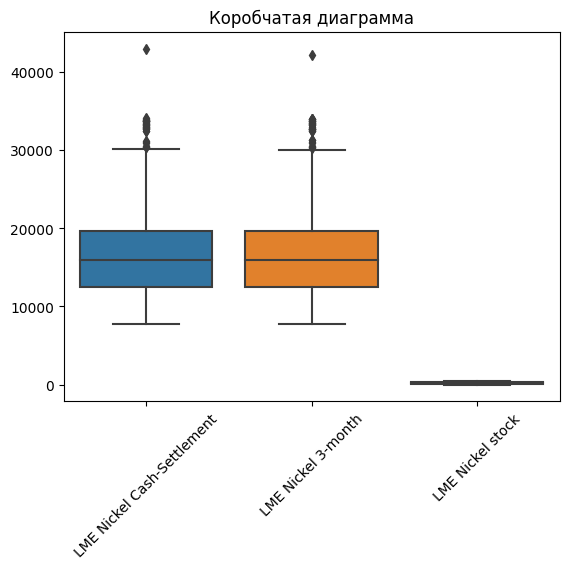

In [122]:
# Удаление ошибки
data.replace(0, np.nan, inplace=True)
data.dropna(inplace=True, axis=0)

# Убедимся в отсутвие пропусков
box = sns.boxplot(data=data)
box.set_title('Коробчатая диаграмма')
box.set_xticklabels(box.get_xticklabels(), rotation=45)

data.describe()

- Для последующего разложения и моделирования было принято решени о произведении интерполяции данных, итоговая точность прогноза от данных действий пострадает не сильно, учитывая, что нас не интересует дневной уровень цены

In [123]:
# Произведем интерполяцию
data = data.resample('d').interpolate(method='linear')
data.reset_index(inplace=True)

In [124]:
# Подготовим таблицу для сдвига фючерсов
data_prognosis = pd.DataFrame(columns=['date'])
start_date = str(data['date'].iloc[-1])
date_range = pd.date_range(start_date, periods=90, freq='D')
data_prognosis['date'] = date_range

# Объединим таблицы
data = pd.concat([data, data_prognosis])

# Отcортируем и вернем индексы
data = data.sort_values(by='date')

# Произведем сдвиг LME Copper 3-month, представляющим своего рода фьючерс на медь
# (точнее представляет цену меди для операций сроком на 3 месяца.
#  Это означает, что цена отражает стоимость меди на рынке с учетом сроковых контрактов на 3 месяца.)
data.iloc[:, 2] = data.iloc[:, 2].shift(90)

# Обрежем нижние nan-ы, т.к. мы получили наши фьючерсы
data = data[data['date'].dt.year != 2008]

display(data.head(), data.tail())

,date,LME Nickel Cash-Settlement,LME Nickel 3-month,LME Nickel stock
365,2009-01-01,11760.000000,15425.000000,78.606
366,2009-01-02,12710.000000,15118.333333,78.822
367,2009-01-03,12608.333333,14811.666667,78.854
368,2009-01-04,12506.666667,14505.000000,78.886
369,2009-01-05,12405.000000,14255.000000,78.918


,date,LME Nickel Cash-Settlement,LME Nickel 3-month,LME Nickel stock
85,2023-12-22,NaN,19283.333333,NaN
86,2023-12-23,NaN,19250.000000,NaN
87,2023-12-24,NaN,18990.000000,NaN
88,2023-12-25,NaN,18900.000000,NaN
89,2023-12-26,NaN,18875.000000,NaN


---

#### Посмотрим на корреляцию между параметрами и целевой переменной

Диапазон планирования равен 90 дней


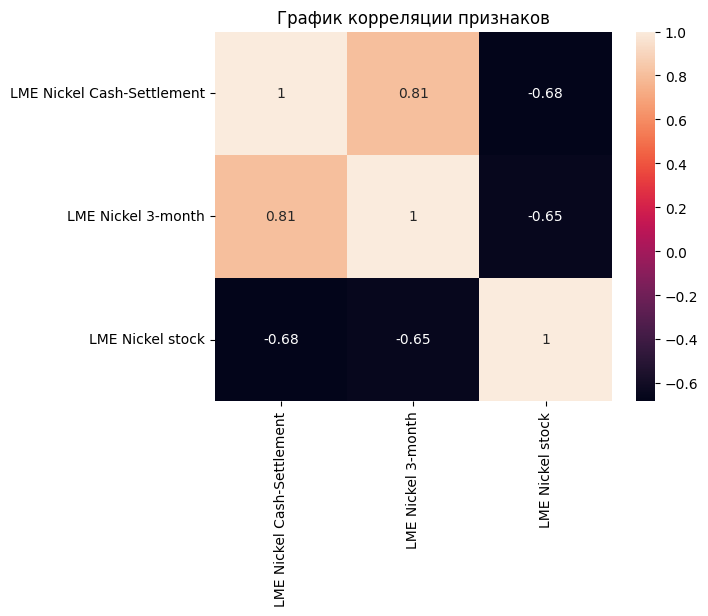

In [125]:
# Выделим ту часть датафрейма, которую мы будем в дальнейшем прогнозировать за счет информации по фьючерсам и спрогнозированным запасам
data_target = data[data.iloc[:, 3].isna()]
data_target.set_index('date', inplace=True)
# А так же ту часть, которую будем использовать для работы
working_data = data[~data.iloc[:, 3].isna()]
working_data.set_index('date', inplace=True)

corr_graph = sns.heatmap(data=working_data.corr(), annot=True)
corr_graph.set_title('График корреляции признаков')
print(f'Диапазон планирования равен {data_target.shape[0]} дней')

> Можно наблюдать высокий уровень корреляции между фьючерсной ценой и спотом, что понадобится нам потом и какую-то между запасами и спотом, что тоже лучше чем ничего.
> На основании того что у нас есть фиты с сильной корреляцией к целевой переменной, мы можем попробовать что-то большее чем стандартный набор для прогнозирования временных рядов.

---

Исходя из первичного анализа данных вырисовывается следующий план:
- Протестировать модели прогноза временных рядов для запасов и цены с последующим логированием
- Протестировать ML- методы линейной регрессии

---

#### Посмотри на распределение показателей с которыми мы будем работать

<Axes: xlabel='LME Nickel Cash-Settlement', ylabel='Count'>

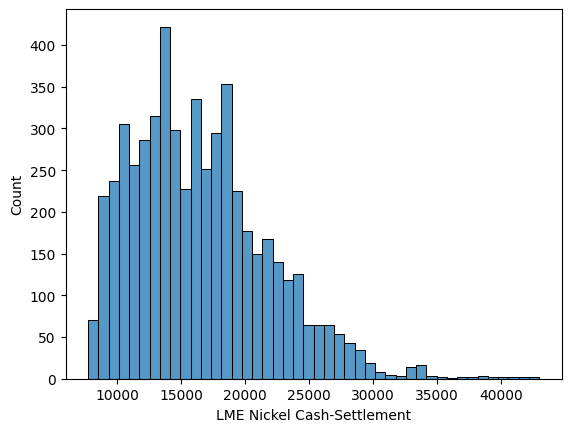

In [126]:
# Посмотрим на распределения цены и запасов
sns.histplot(data.iloc[:, 1])

По цене нормальное распределение

<Axes: xlabel='LME Nickel stock', ylabel='Count'>

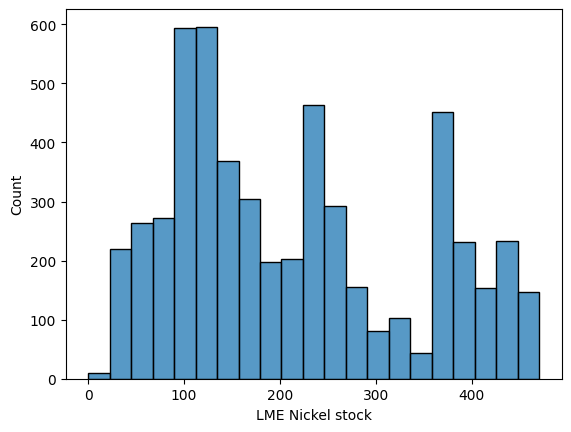

In [127]:
sns.histplot(data.iloc[:, -1])

<Axes: xlabel='LME Nickel stock', ylabel='Count'>

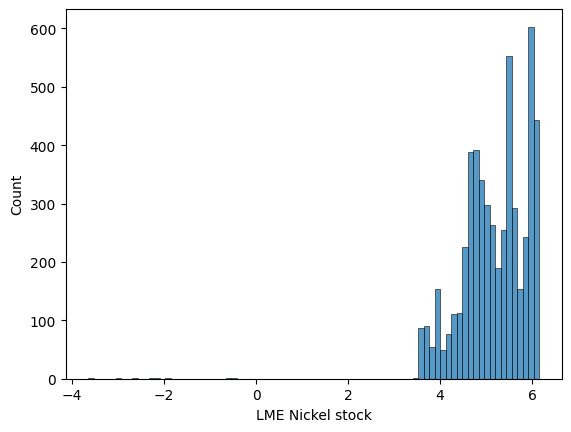

In [128]:
sns.histplot(np.log(data.iloc[:, -1]))

По запасам логнормальное, это может понадобиться в будущем (не понадобится, в итоге лучше принимать его за нормальное и не логарифмировать, но об этом позже)

---

Предварительный вывод и личные коментарии:
- Наша задача сформировать прогноз на 90 дней вперед, исходя из предположения о том, что сдвинутые на 3 месяца данные по фьючерсам (со сроком исполнения в 3 месяца, потому такой сдвиг) имеют высокую корреляцию с показателем целевой переменной спотовой цены.

- Так же нужно отметить достаточный уровень обратной корреляции между спотом и запасами, что логично исходя из закона о спросе и предложении, при этом влияние запасов на фьючерсы не несет характер мультиколлинеарности.

- Хотел бы отметить, что был эксперимент с внедрением данных из разных источников, но с целевой переменной корреляция была слишком слаба, при этом сильно усложнялся этап парсинга и последующей автоматизации скрипта, который в планах перевести на микросервис, т.е. затраты и потери от внедрения доп информации был слишком дорог для реального применения.

----

### Часть 1.

### Прогнозирование временного ряда запасов (LME stock) и спотовой цены (LME Cash-Settlement)

#### Первичный анализ данных.

In [129]:
# Будем прогнозировать временной ряд LME Copper stock и
# LME Copper Cash-Settlement, т.к. данная переменная имеет непосредственную связь с фактором времени
# Для начала проведем декомпозицию временных рядов

stock = working_data.iloc[:, 2]
spot = working_data.iloc[:, 0]

decompose_stock = seasonal_decompose(stock)
decompose_spot = seasonal_decompose(spot)

# Выделим тренд, сезонность и остатки, интерполируем и заполним нулями первые элементы
trend_stock = decompose_stock.trend
seasonal_stock = decompose_stock.seasonal
seasonal_stock = seasonal_stock.resample('d').interpolate(method='linear')
seasonal_stock.fillna(0, inplace=True)
residuals_stock = decompose_stock.resid
residuals_stock = residuals_stock.resample('d').interpolate(method='linear')
residuals_stock.fillna(0, inplace=True)

trend_spot = decompose_spot.trend
seasonal_spot = decompose_spot.seasonal
seasonal_spot = seasonal_spot.resample('d').interpolate(method='linear')
seasonal_spot.fillna(0, inplace=True)
resid_spot = decompose_spot.resid
resid_spot = resid_spot.resample('d').interpolate(method='linear')
resid_spot.fillna(0, inplace=True)

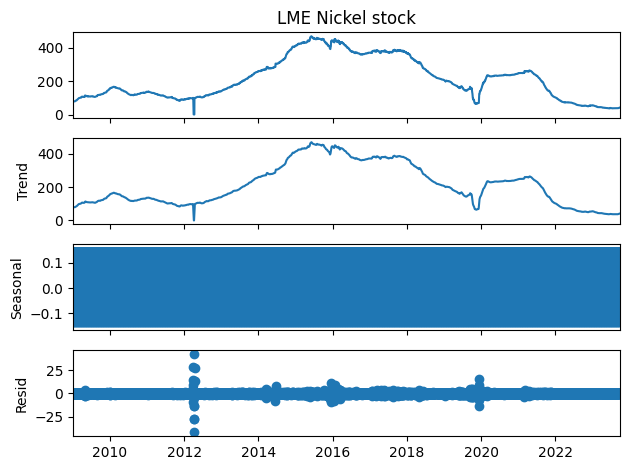

In [130]:
# Произвведем декомпозицию ряда
decompose_stock.plot()
plt.show()

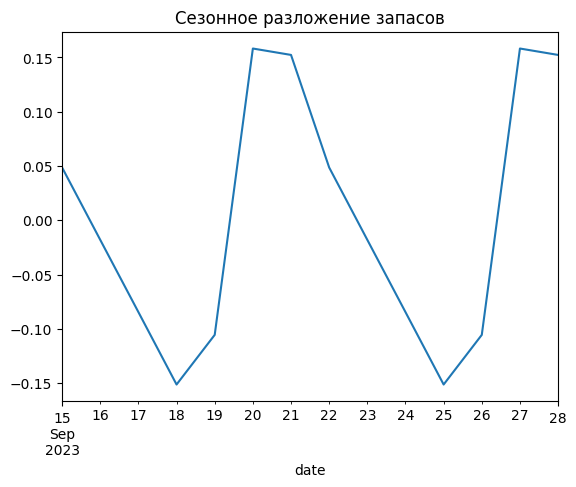

In [131]:
# Приблизим сезонность
graph = decompose_stock.seasonal[-14:].plot()
graph.set_title('Сезонное разложение запасов')
plt.show()

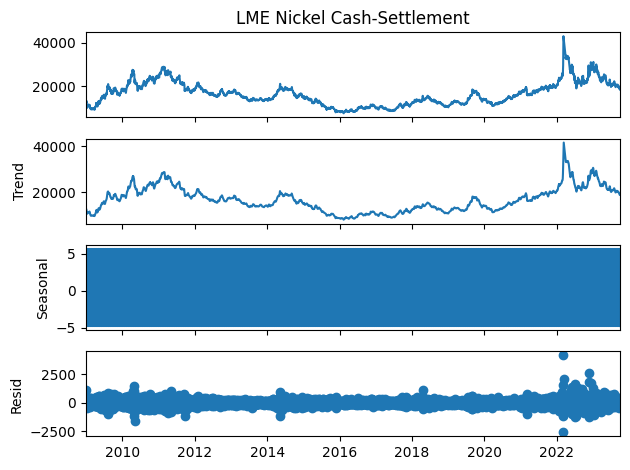

In [132]:
# Для цены
decompose_spot.plot()
plt.show()

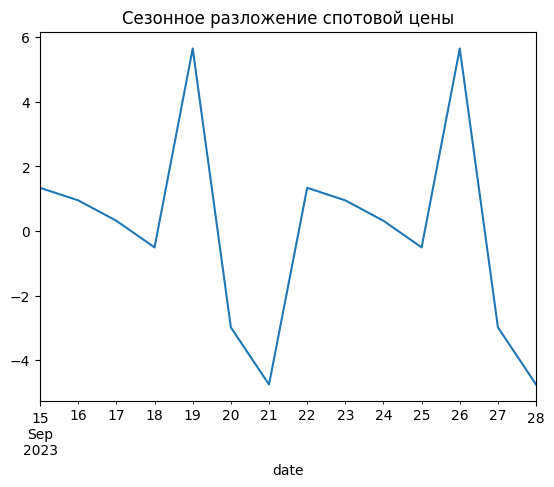

In [133]:
graph = decompose_spot.seasonal[-14:].plot()
graph.set_title('Сезонное разложение спотовой цены')
plt.show()

> Вывод: Мы можем наблюдать большие остатки при сезонном разложении спотовых цен, вероятной причиной этого может быть влияние экзогенных факторов, от глобальных циклов экономики и геополитических сдвигов, до возможных спекулятивных манипуляций, уже на данном этапе можно сказать, что прогнозирование цены влоб, через ARIMA будет не самой разумной идеей. Возможно сработал бы подход с анализом и прогнозом остатков параллельно с основной компонентой.

> С запасами картина более радужная, физические запасы металла на бирже величина менее волатильная, что вселяет надежду в возможность формирования прогноза данной величины и использования ее как фактора в другом типе мл, но об этом позже.

> Так же нужно отметить сезонность равную периоду 7 дней (5 дней ьез интерполяции), что характерно для биржевых показателей.


---

Единичных корней нет, ряд стационарен
{'p_value': -10.838214740828446, 'crit_value (5%)': -2.8620798864723103}
Единичных корней нет, ряд стационарен
{'p_value': -14.493818617649577, 'crit_value (5%)': -2.8620798864723103}


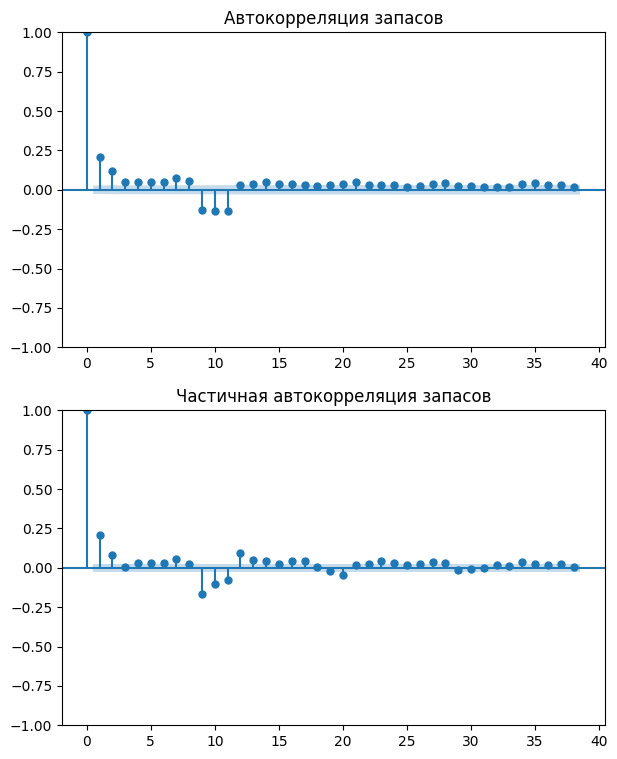

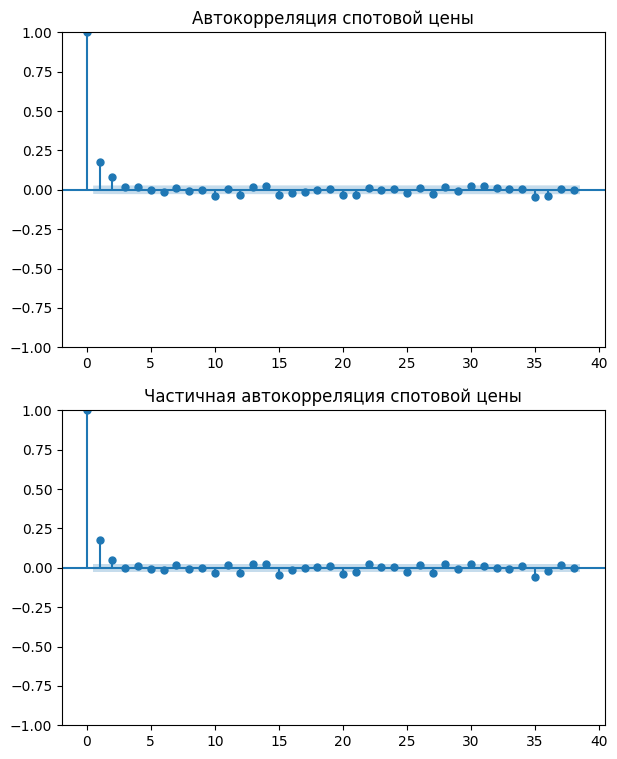

In [134]:
# Проведем тест стационарности выведем графики acf и pacf
stationary_test(stock.diff().dropna(), name='запасов')
stationary_test(spot.diff().dropna(), name='спотовой цены')

> Вывод: оба ряда стационарны при дифференцировании 1 порядка, стоит отметить что ряд запасов условно стационарен (не все статистика близка к порогу 5%)

> p для запасов равен 1 (исходя из pacf графика это значение равно 2, но лучшие результаты были достигнуты именно при значении 1)

> p для спота равен 2 (так же исходя из pacf)

In [135]:
p_stock = 1
d_stock = 0
q_stock = 0

p_spot = 1
d_spot = 0
q_spot = 0

---

#### Baseline модель для данного этапа исследования.

##### Здесь мы убьем двух зайцев и сразу спрогнозируем и спот и запасы через базовую авторегрессионную модель, далее мы так же будем прогнозировать спок прайс, хоть изначально и планировалось сформировать для него конечный прогноз через random-forest regressor через фиты фьючерса и запасов, но может статься что по итогу выиграет простая стратегия.

In [136]:
# Выделим тренировочную и тестовую выборки
train_stock = stock[:-len(data_target)]
test_stock = stock[-len(data_target):]

train_spot = spot[:-len(data_target)]
test_spot = spot[-len(data_target):]

# Сделаем то же самое для сезонных компонент
seasonal_stock_train = seasonal_stock[:-len(data_target)]
seasonal_stock_test = seasonal_stock[-len(data_target):]

residuals_stock_train = residuals_stock[:-len(data_target)]
residuals_stock_test = residuals_stock[-len(data_target):]

seasonal_spot_train = seasonal_spot[:-len(data_target)]
seasonal_spot_test = seasonal_spot[-len(data_target):]

resid_spot_train = resid_spot[:-len(data_target)]
resid_spot_test = resid_spot[-len(data_target):]

# И попробуем создать корректировку для послежующих прогнозов через базовую модель
ar_model_stock_sesonal = AutoReg(seasonal_stock_train, lags=1).fit()
ar_model_stock_resid = AutoReg(residuals_stock_train, lags=1).fit()

ar_model_spot_seasonal = AutoReg(seasonal_spot_train, lags=1).fit()
ar_model_spot_resid = AutoReg(resid_spot_train, lags=1).fit()

In [137]:
# Наши корректировки
stock_seasonal_mod = ar_model_stock_sesonal.predict(start=len(
    seasonal_stock_train), end=len(seasonal_stock_train)+len(seasonal_stock_test)-1)
stock_resid_mod = ar_model_stock_resid.predict(start=len(
    residuals_stock_train), end=len(residuals_stock_train)+len(residuals_stock_test)-1)

spot_seasonal_mod = ar_model_spot_seasonal.predict(start=len(
    seasonal_spot_train), end=len(seasonal_spot_train)+len(seasonal_spot_test)-1)
spot_resid_mod = ar_model_spot_resid.predict(start=len(
    resid_spot_train), end=len(resid_spot_train)+len(resid_spot_test)-1)

In [138]:
# Произведем прогнозирование
ar_model_stock = AutoReg(train_stock, lags=p_stock, seasonal=True).fit()
ar_model_spot = AutoReg(train_spot, lags=p_spot, seasonal=True).fit()

# Сделаем предсказание
pred_ar_stock = ar_model_stock.predict(
    start=len(train_stock), end=len(train_stock)+len(test_stock)-1)
pred_ar_spot = ar_model_spot.predict(
    start=len(train_spot), end=len(train_spot)+len(test_spot)-1)

# Подгоним полученные предсказания компонентами сезонного разложения
pred_ar_stock = pred_ar_stock + stock_seasonal_mod + stock_resid_mod

pred_ar_spot = pred_ar_spot + spot_seasonal_mod + spot_resid_mod

# Построим доверительный интервал
forecast_stock = ar_model_stock.get_prediction(
    start=len(train_stock), end=len(train_stock)+len(test_stock)-1)
conf_stock = forecast_stock.conf_int(alpha=0.05)

forecast_spot = ar_model_spot.get_prediction(
    start=len(train_spot), end=len(train_spot)+len(test_spot)-1)
conf_spot = forecast_spot.conf_int(alpha=0.05)

In [139]:
# Оценим метрики и залогируем результаты
metric_stock = metrics_calculation(
    test_stock, pred_ar_stock, name='AR-baseline-stock')
log_metrics_stock(metric_stock)

metric_spot = metrics_calculation(
    test_spot, pred_ar_spot, name='AR-baseline-spot')
log_metrics_spot(metric_spot)

RMSE для AR-baseline-stock: 1.573
MAE для AR-baseline-stock: 1.44
MAPE для AR-baseline-stock: 3.8%


RMSE для AR-baseline-spot: 814.267
MAE для AR-baseline-spot: 638.847
MAPE для AR-baseline-spot: 3.1%




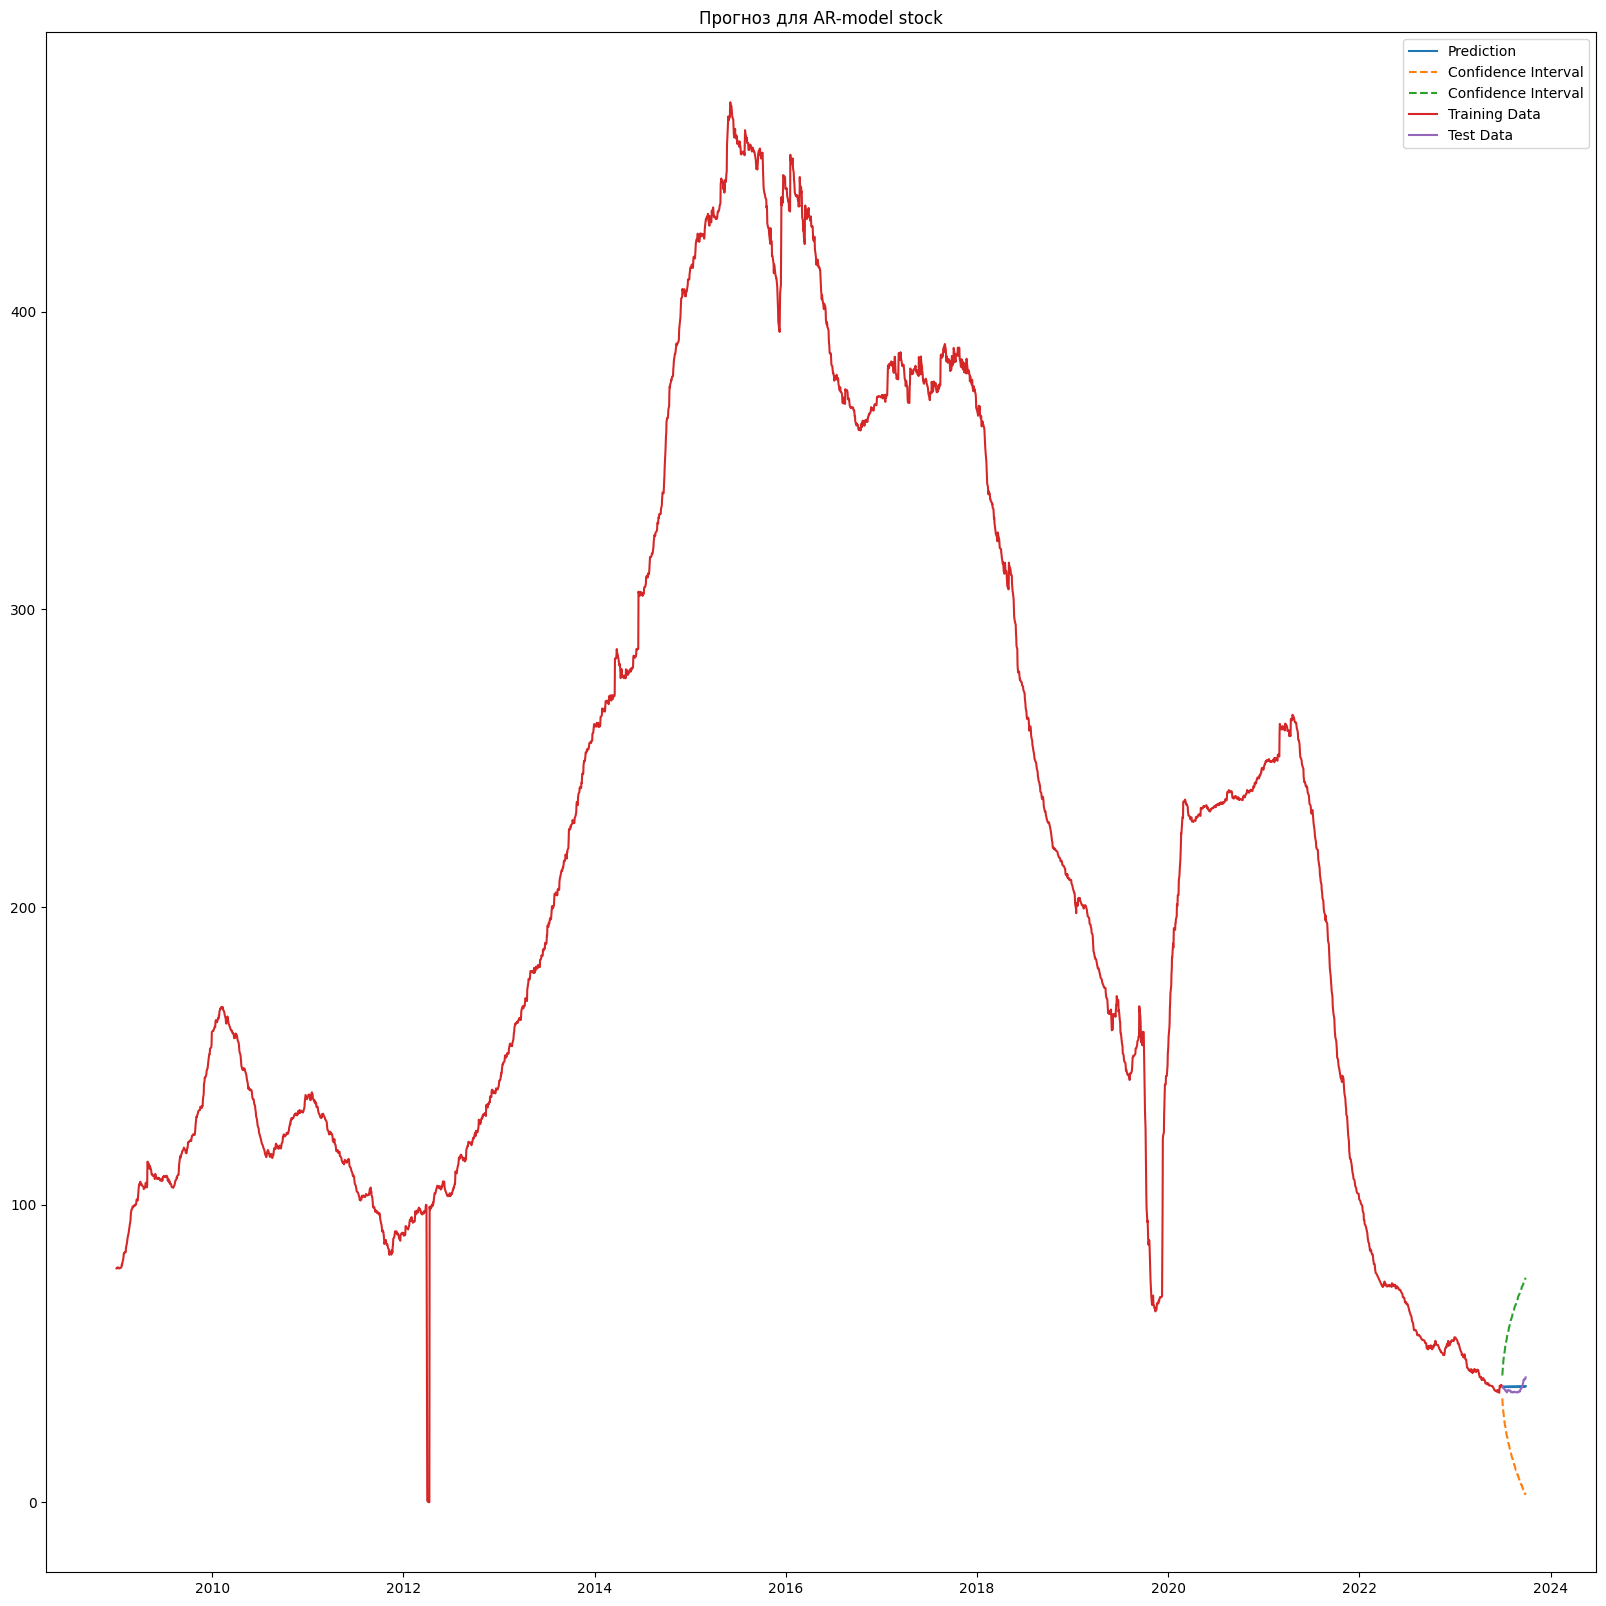

In [140]:
# Выведем график прогноза с доверительными интервалами
fig = plt.figure(figsize=(20, 20))
visualisation_prog(
    pred_ar_stock, conf_stock,
    train_stock, test_stock, name='AR-model stock'
)

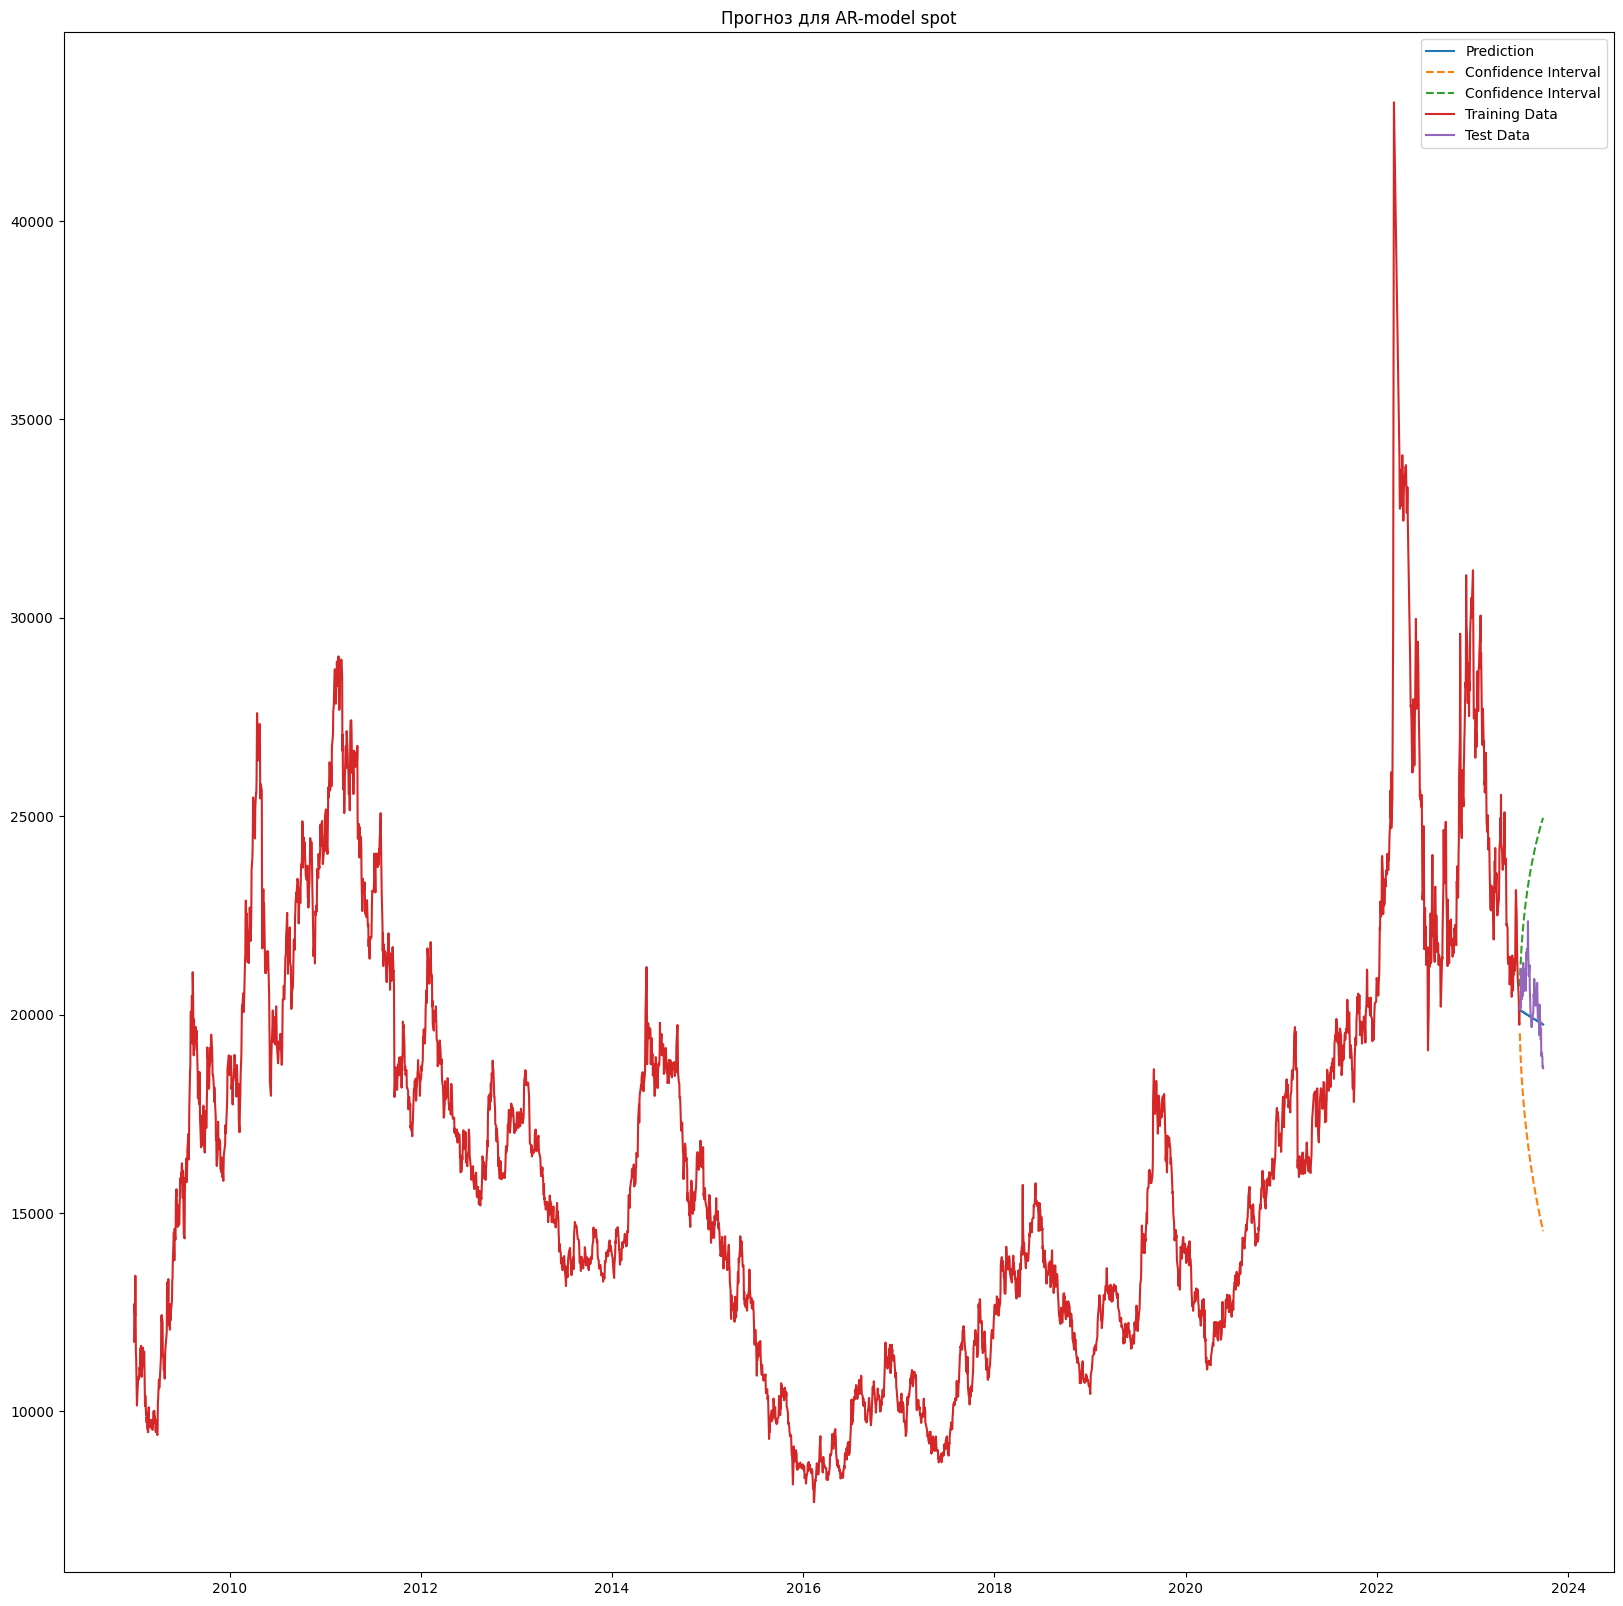

In [141]:
fig = plt.figure(figsize=(20, 20))
visualisation_prog(
    pred_ar_spot, conf_spot,
    train_spot, test_spot, name='AR-model spot'
)

> Вывод: Весьма неожиданный результат для базовой модели спотовой цены (для нас это таргет который мы и планируем спрогнозировать), с учетом того, что в бенчмарках консалтинговых и аналитических агенств допускается разброс в 300 долларов, мы получили значительно большую точность при больших остатках на декомпозиции и околонулевой обработке данных. Данной точности вполне хватило бы для легковестного бенчмарка для использования в работе

> Результат на запасах при этом показал вполне предсказуемый для baseline модели.

> Так же стоти отметить следующее:
 * Прогноз не уловил дисперисю
 * 95% доверительный интервал весьма широк
> Что говорит о вероято слабой прогностической способности в бою (если бы мы ставили целью прогноз именно запасов).

---

### ARIMA прогноз (т.к. ряды изначально не стационарны их порядок дифференцирования равен 1, d=1)

In [142]:
# Используем модель ARIMA
arima_model_stock = ARIMA(train_stock, order=(p_stock, d_stock, q_stock)).fit()
arima_model_spot = ARIMA(train_spot, order=(p_spot, d_stock, q_stock)).fit()

# Прогноз
pred_arima_stock = arima_model_stock.predict(
    start=len(train_stock), end=len(train_stock)+len(test_stock)-1)

pred_arima_spot = arima_model_spot.predict(
    start=len(train_spot), end=len(train_spot)+len(test_spot)-1)

# Модификация прогноза
pred_arima_stock = pred_arima_stock + stock_seasonal_mod + stock_resid_mod

pred_arima_spot = pred_arima_spot + spot_seasonal_mod + spot_resid_mod

# Доверительные интервалы
forecast_stock = arima_model_stock.get_forecast(steps=len(test_stock))
conf_stock = forecast_stock.conf_int(alpha=0.05)

forecast_spot = arima_model_spot.get_forecast(steps=len(test_spot))
conf_spot = forecast_spot.conf_int(alpha=0.05)

In [143]:
# Оценим метрики и залогируем результаты
log_metrics_stock(metrics_calculation(
    test_stock, pred_arima_stock, name='ARIMA-stock'))
log_metrics_spot(metrics_calculation(
    test_spot, pred_arima_spot, name='ARIMA-spot'))

RMSE для ARIMA-stock: 1.76
MAE для ARIMA-stock: 1.64
MAPE для ARIMA-stock: 4.3%


RMSE для ARIMA-spot: 836.797
MAE для ARIMA-spot: 667.092
MAPE для ARIMA-spot: 3.2%




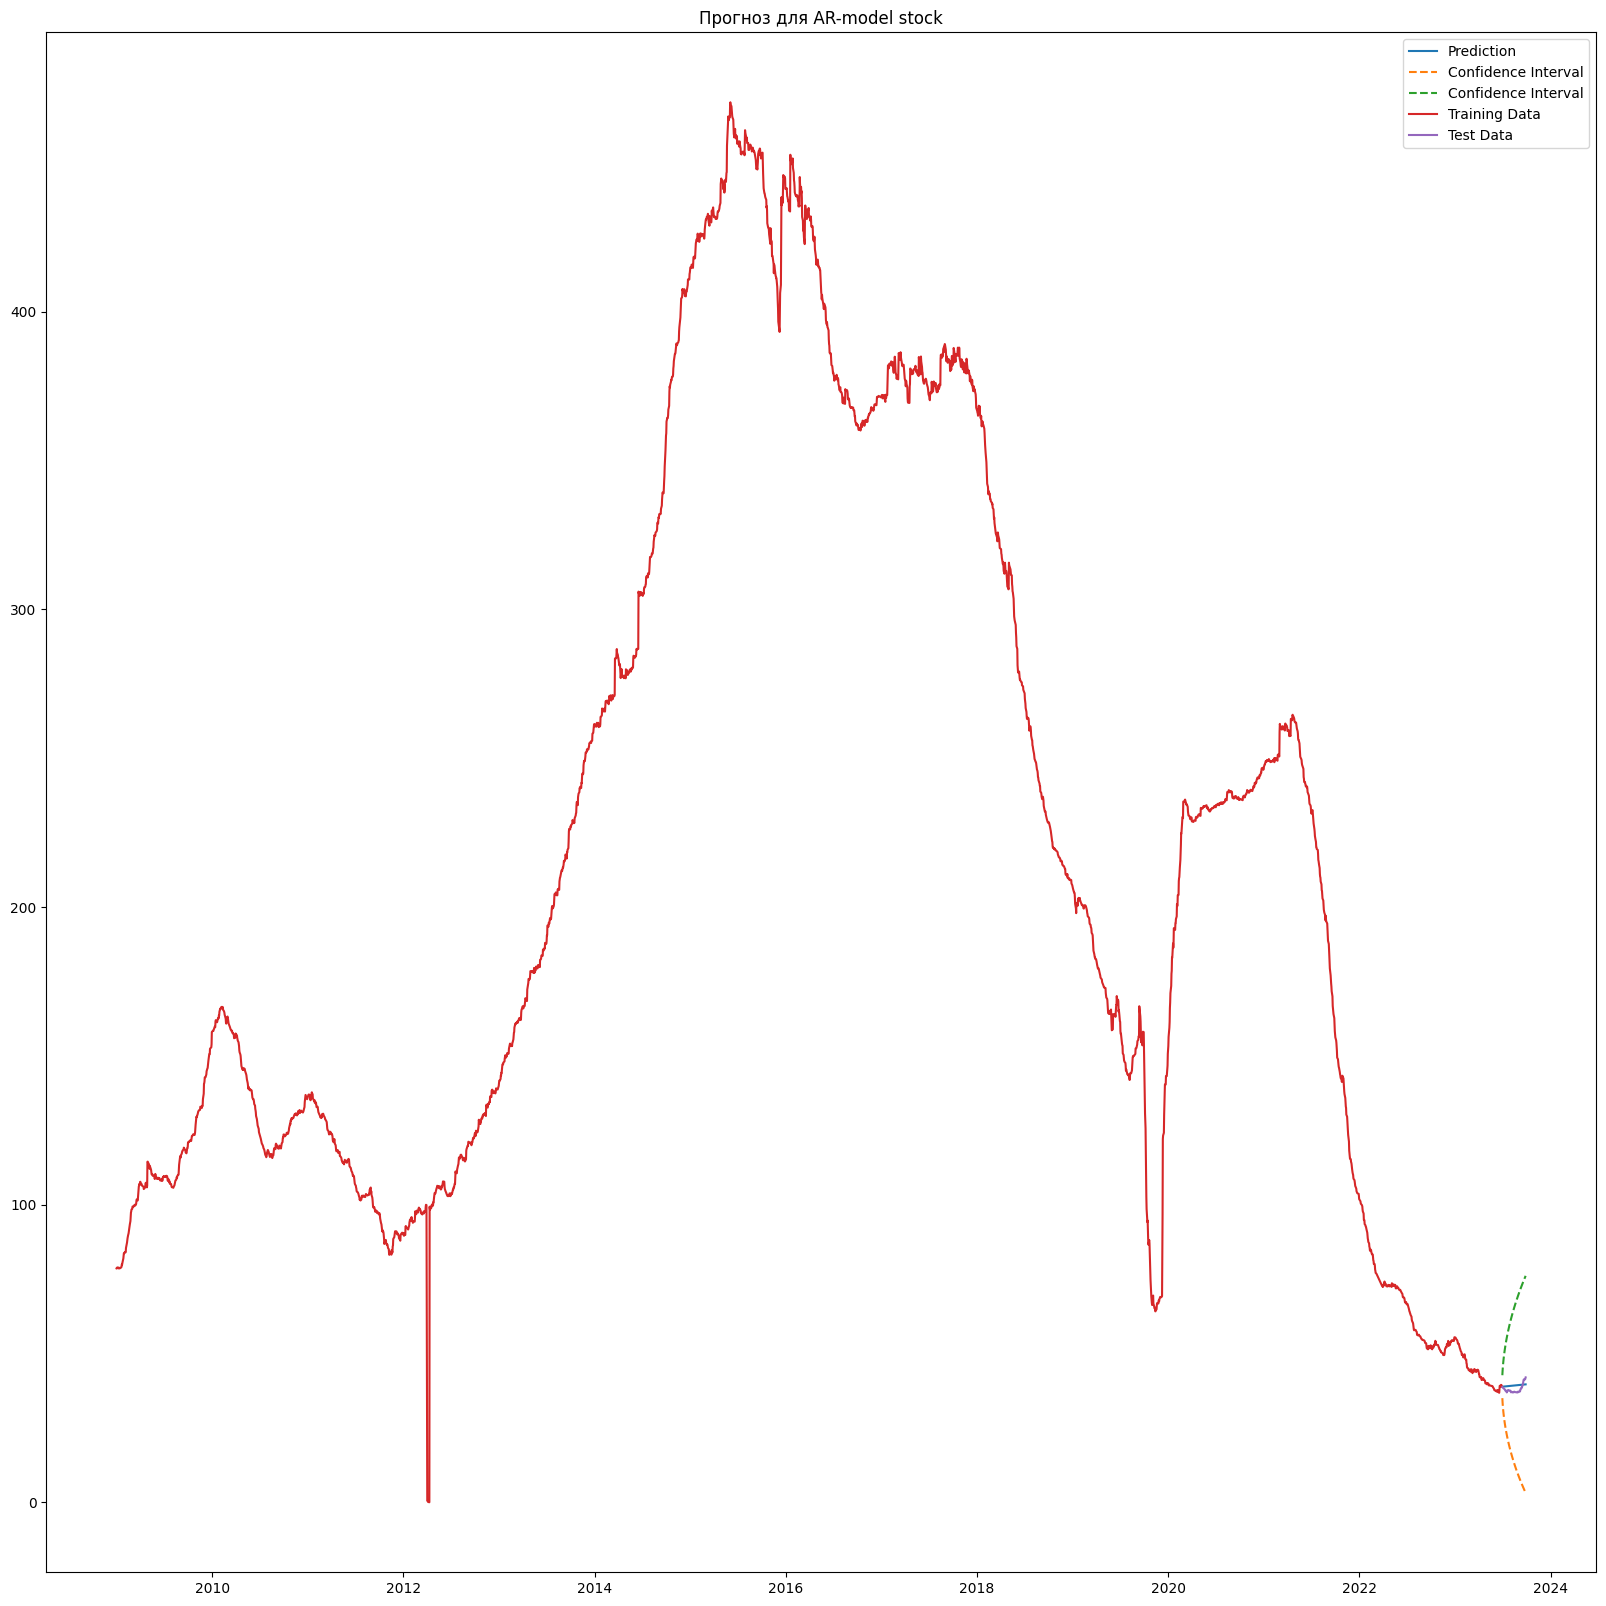

In [144]:
# Выведем график прогноза с доверительными интервалами
fig = plt.figure(figsize=(20, 20))
visualisation_prog(
    pred_arima_stock, conf_stock,
    train_stock, test_stock, name='AR-model stock'
)

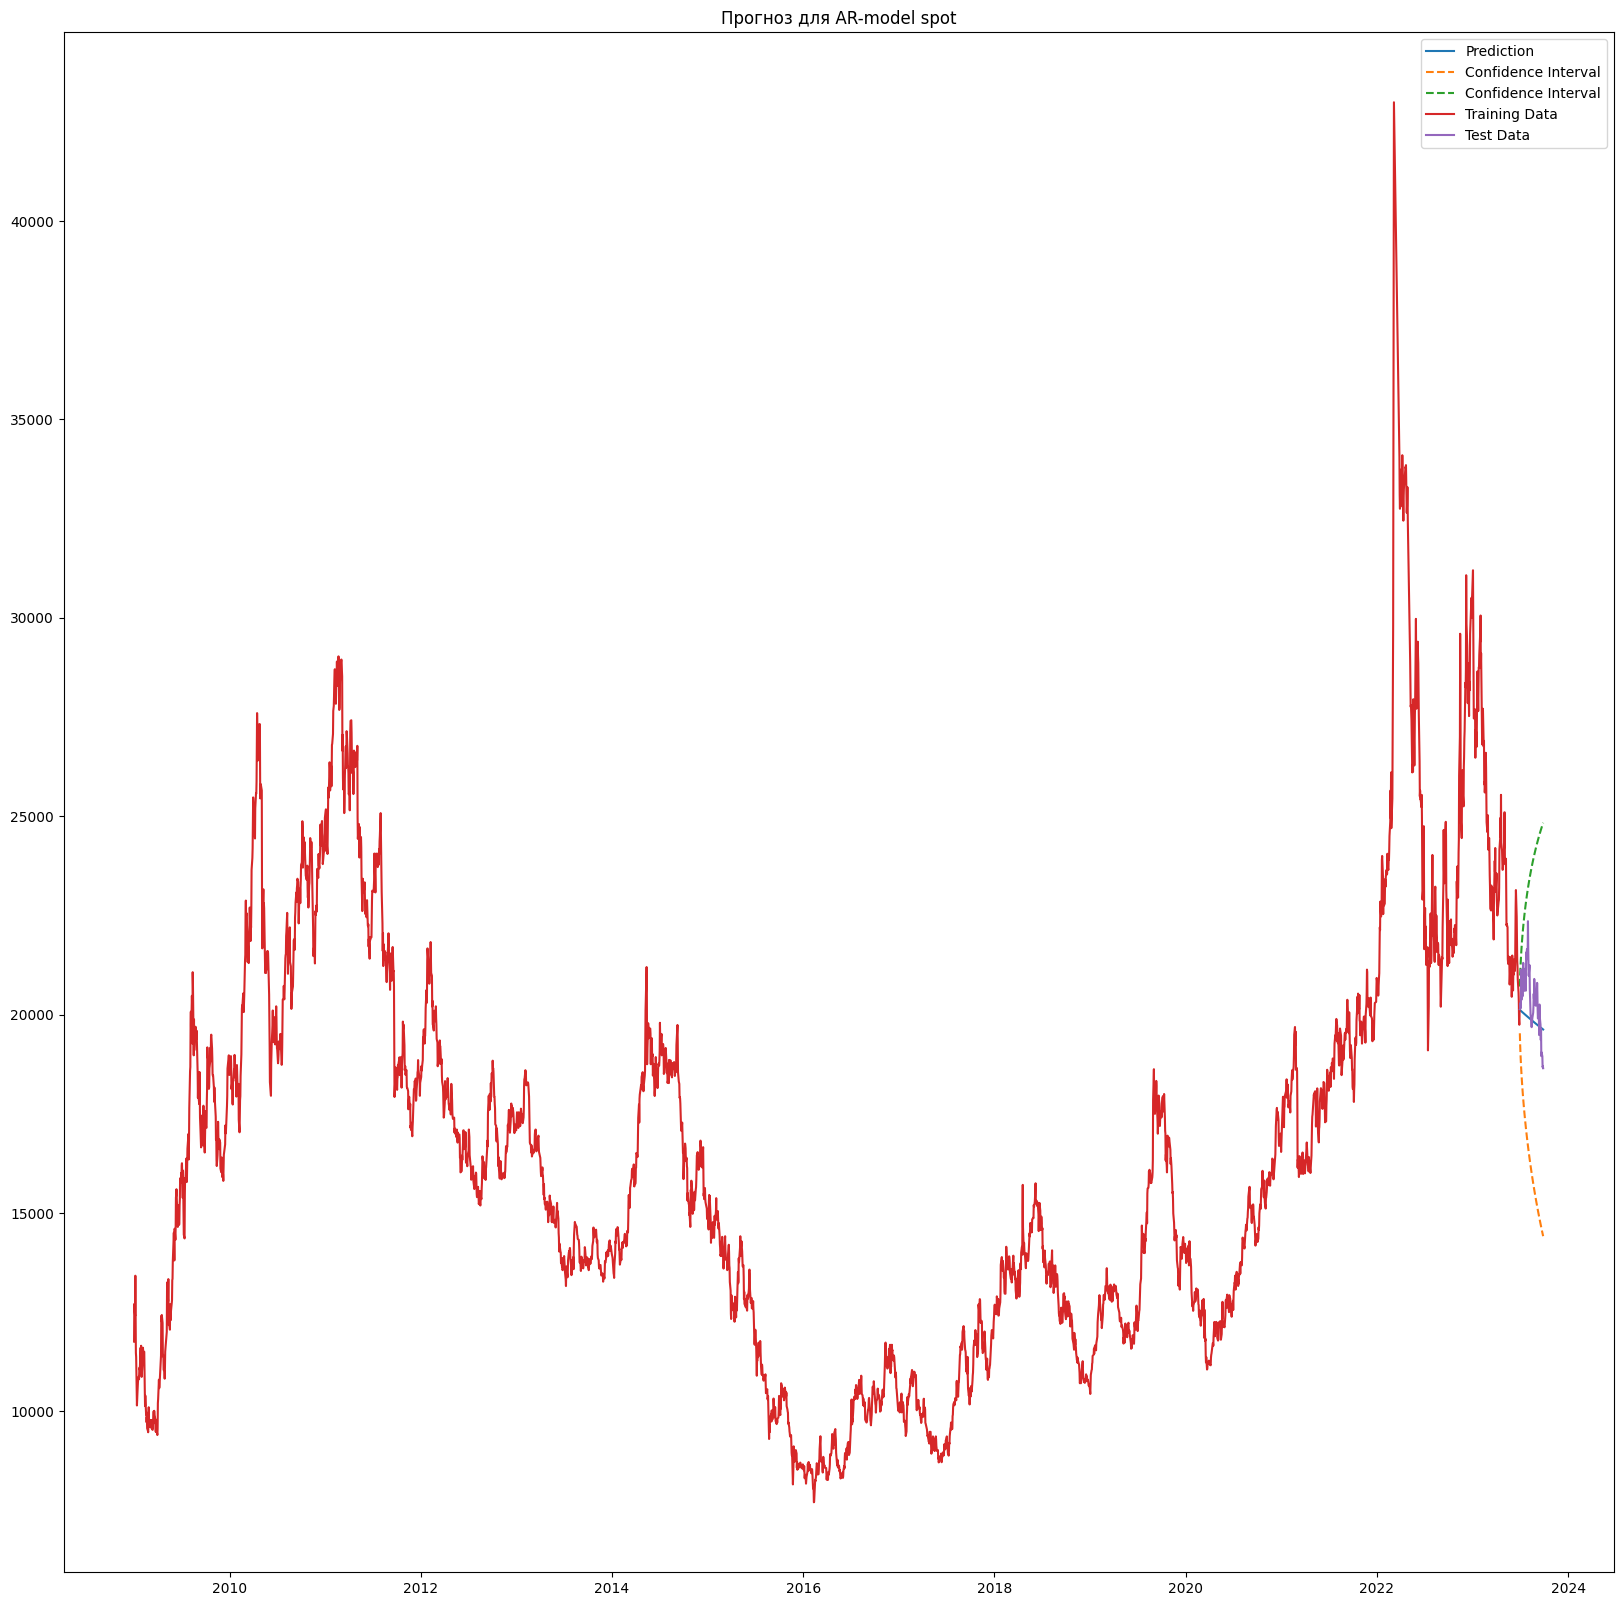

In [145]:
fig = plt.figure(figsize=(20, 20))
visualisation_prog(
    pred_arima_spot, conf_spot,
    train_spot, test_spot, name='AR-model spot'
)

> В сравнение с baseline моделью произошло незначительное падение метрики spot-price, и незначительное увеличение stocks, графики так же отражают весьма сомнительную прогностическую способность для дневного анализа, НО, и это важно подчеркнуть, так как нашей задачей является СРЕДНЯЯ ЦЕНА за тестовый период, можно сказать, что задача, исходя из проделанного на данный момент анализа, вполне достижима

> Так же отсутсвует чувствительность по дисеперсии и гигантские доверительные интервалы.

---

### PMDARIMA прогноз, попробуем подобрать внутренние параметры модели автоматом.

In [146]:
model_stock = pm.auto_arima(
    train_stock, start_p=1, start_q=1,
    test='adf',
    max_p=20, max_q=20, m=7,
    start_P=0, seasonal=True,
    d=1, D=1, trace=True,
    error_action='ignore',
    suppress_warnings=True,
    stepwise=True
)
model_stock.summary()

Performing stepwise search to minimize aic


 ARIMA(1,1,1)(0,1,1)[7]             : AIC=inf, Time=3.31 sec
 ARIMA(0,1,0)(0,1,0)[7]             : AIC=25410.531, Time=0.11 sec
 ARIMA(1,1,0)(1,1,0)[7]             : AIC=23814.858, Time=0.50 sec
 ARIMA(0,1,1)(0,1,1)[7]             : AIC=inf, Time=1.89 sec
 ARIMA(1,1,0)(0,1,0)[7]             : AIC=25255.085, Time=0.12 sec
 ARIMA(1,1,0)(2,1,0)[7]             : AIC=23215.984, Time=1.30 sec
 ARIMA(1,1,0)(2,1,1)[7]             : AIC=inf, Time=4.61 sec
 ARIMA(1,1,0)(1,1,1)[7]             : AIC=inf, Time=2.00 sec
 ARIMA(0,1,0)(2,1,0)[7]             : AIC=23393.098, Time=0.72 sec
 ARIMA(2,1,0)(2,1,0)[7]             : AIC=23183.229, Time=1.25 sec
 ARIMA(2,1,0)(1,1,0)[7]             : AIC=23770.187, Time=0.70 sec
 ARIMA(2,1,0)(2,1,1)[7]             : AIC=inf, Time=5.12 sec
 ARIMA(2,1,0)(1,1,1)[7]             : AIC=inf, Time=2.82 sec
 ARIMA(3,1,0)(2,1,0)[7]             : AIC=23180.285, Time=1.66 sec
 ARIMA(3,1,0)(1,1,0)[7]             : AIC=23746.814, Time=0.90 sec
 ARIMA(3,1,0)(2,1,1)[7]        

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                                 y   No. Observations:                 5294
Model:             SARIMAX(4, 1, 0)x(2, 1, 0, 7)   Log Likelihood              -11579.579
Date:                           Fri, 29 Sep 2023   AIC                          23173.159
Time:                                   08:30:46   BIC                          23219.168
Sample:                               01-01-2009   HQIC                         23189.239
                                    - 06-30-2023                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1636      0.002     75.529      0.000       0.159       0.168
ar.L2          0.0733      0.004     19.077      0.000       0.066       0.081
ar.L3          0.0244      0.004      5.644      0.000       0.016       0.033
ar.L4          0.0417      0.006      7.567      0.000       0.031       0.052
ar.S.L7       -0.6370      0.001   -564.746      0.000      -0.639      -0.635
ar.S.L14      -0.3181      0.001   -261.151      0.000      -0.321      -0.316
sigma2         4.6772      0.007    683.614      0.000       4.664       4.691
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):         152394954.66
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               0.14   Skew:                            14.38
Prob(H) (two-sided):                  0.00   Kurtosis:                       834.32
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [147]:
model_spot = pm.auto_arima(
    train_spot, start_p=1, start_q=1,
    test='adf',
    max_p=20, max_q=20, m=7,
    start_P=0, seasonal=True,
    d=1, D=1, trace=True,
    error_action='ignore',
    suppress_warnings=True,
    stepwise=True
)
model_spot.summary()

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[7]             : AIC=inf, Time=3.04 sec
 ARIMA(0,1,0)(0,1,0)[7]             : AIC=78905.955, Time=0.08 sec
 ARIMA(1,1,0)(1,1,0)[7]             : AIC=77129.286, Time=0.59 sec
 ARIMA(0,1,1)(0,1,1)[7]             : AIC=inf, Time=1.87 sec
 ARIMA(1,1,0)(0,1,0)[7]             : AIC=78699.905, Time=0.11 sec
 ARIMA(1,1,0)(2,1,0)[7]             : AIC=76647.397, Time=1.71 sec
 ARIMA(1,1,0)(2,1,1)[7]             : AIC=inf, Time=5.91 sec
 ARIMA(1,1,0)(1,1,1)[7]             : AIC=inf, Time=2.20 sec
 ARIMA(0,1,0)(2,1,0)[7]             : AIC=76846.142, Time=0.63 sec
 ARIMA(2,1,0)(2,1,0)[7]             : AIC=76633.715, Time=2.37 sec
 ARIMA(2,1,0)(1,1,0)[7]             : AIC=77107.697, Time=1.28 sec
 ARIMA(2,1,0)(2,1,1)[7]             : AIC=inf, Time=7.31 sec
 ARIMA(2,1,0)(1,1,1)[7]             : AIC=inf, Time=3.34 sec
 ARIMA(3,1,0)(2,1,0)[7]             : AIC=76635.537, Time=2.72 sec
 ARIMA(2,1,1)(2,1,0)[7]             : AIC=inf, Time=3.4

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                                 y   No. Observations:                 5294
Model:             SARIMAX(2, 1, 0)x(2, 1, 0, 7)   Log Likelihood              -38311.858
Date:                           Fri, 29 Sep 2023   AIC                          76633.715
Time:                                   08:31:36   BIC                          76666.579
Sample:                               01-01-2009   HQIC                         76645.201
                                    - 06-30-2023                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1822      0.006     32.883      0.000       0.171       0.193
ar.L2          0.0544      0.006      8.418      0.000       0.042       0.067
ar.S.L7       -0.6585      0.006   -112.255      0.000      -0.670      -0.647
ar.S.L14      -0.2941      0.006    -48.418      0.000      -0.306      -0.282
sigma2      1.156e+05    854.955    135.266      0.000    1.14e+05    1.17e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):             47827.20
Prob(Q):                              0.88   Prob(JB):                         0.00
Heteroskedasticity (H):               1.57   Skew:                             0.41
Prob(H) (two-sided):                  0.00   Kurtosis:                        17.71
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [148]:
model_stock.get_params()

{'maxiter': 50,
 'method': 'lbfgs',
 'order': (4, 1, 0),
 'out_of_sample_size': 0,
 'scoring': 'mse',
 'scoring_args': {},
 'seasonal_order': (2, 1, 0, 7),
 'start_params': None,
 'suppress_warnings': True,
 'trend': None,
 'with_intercept': False}

In [149]:
with open('./data/ar_stock_nk.pkl', 'wb') as pkl_file:
    pickle.dump(model_stock.get_params(), pkl_file)

In [150]:
model_spot.get_params()

{'maxiter': 50,
 'method': 'lbfgs',
 'order': (2, 1, 0),
 'out_of_sample_size': 0,
 'scoring': 'mse',
 'scoring_args': {},
 'seasonal_order': (2, 1, 0, 7),
 'start_params': None,
 'suppress_warnings': True,
 'trend': None,
 'with_intercept': False}

In [151]:
with open('./data/ar_spot_nk.pkl', 'wb') as pkl_file:
    pickle.dump(model_spot.get_params(), pkl_file)

---

#### До этого момента я не сравнивал модели по критерию AIC ввиду того что по итогу все равно бы начал перебирать внутренние параметры для последующего использования SARIMAX


### ARIMA - по подобранным параметрам

In [152]:
order_stock = model_stock.order
seasonal_order_stock = model_stock.seasonal_order

order_spot = model_spot.order
seasonal_order_spot = model_spot.seasonal_order

In [153]:
# Используем модель ARIMA
pmarima_model_stock = ARIMA(
    train_stock, order=order_stock,
    seasonal_order=seasonal_order_stock).fit()

pmarima_model_spot = ARIMA(
    train_spot, order=order_spot,
    seasonal_order=seasonal_order_spot).fit()

# Прогноз
pred_pmarima_stock = pmarima_model_stock.predict(
    start=len(train_stock), end=len(train_stock)+len(test_stock)-1)

pred_pmarima_spot = pmarima_model_spot.predict(
    start=len(train_spot), end=len(train_spot)+len(test_spot)-1)

# Доверительные интервалы
forecast_stock = pmarima_model_stock.get_forecast(steps=len(test_stock))
conf_stock = forecast_stock.conf_int(alpha=0.05)

forecast_spot = pmarima_model_spot.get_forecast(steps=len(test_spot))
conf_spot = forecast_spot.conf_int(alpha=0.05)

# Оценим метрики и залогируем результаты
log_metrics_stock(metrics_calculation(
    test_stock, pred_pmarima_stock, name='PMARIMA-stock'))
log_metrics_spot(metrics_calculation(
    test_spot, pred_pmarima_spot, name='PMARIMA-spot'))

RMSE для PMARIMA-stock: 4.692
MAE для PMARIMA-stock: 4.361
MAPE для PMARIMA-stock: 11.5%


RMSE для PMARIMA-spot: 6438.022
MAE для PMARIMA-spot: 5806.639
MAPE для PMARIMA-spot: 28.799999999999997%




> Ухудшение метрик, усложнение можели не идет на пользу.

---

### SARIMAX

In [154]:
# Инициализация модели
sarimax_model_stock = SARIMAX(
    train_stock, order=order_stock, seasonal_order=seasonal_order_stock).fit()

sarimax_model_spot = SARIMAX(
    train_spot, order=order_spot, seasonal_order=seasonal_order_spot).fit()

# Спрогнозируем
pred_sarimax_stock = sarimax_model_stock.predict(
    start=len(train_stock), end=len(train_stock)+len(test_stock)-1)

pred_sarimax_spot = sarimax_model_spot.predict(
    start=len(train_spot), end=len(train_spot)+len(test_spot)-1)

# Построим доверительные интервалы
forecast_stock = sarimax_model_stock.get_forecast(steps=len(test_stock))
conf_stock = forecast_stock.conf_int(alpha=0.05)

forecast_spot = sarimax_model_spot.get_forecast(steps=len(test_spot))
conf_spot = forecast_spot.conf_int(alpha=0.05)


# Оценим метрики и залогируем результаты
log_metrics_stock(metrics_calculation(
    test_stock, pred_sarimax_stock, name='SARIMAX-stock'))
log_metrics_spot(metrics_calculation(
    test_spot, pred_sarimax_spot, name='SARIMAX-spot'))

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.21937D+00    |proj g|=  1.17110D-01


 This problem is unconstrained.



At iterate    5    f=  2.18730D+00    |proj g|=  2.38833D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7      7     10      1     0     0   3.624D-06   2.187D+00
  F =   2.1873024844564428     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.27026D+00    |proj g|=  4.60915D-03

At iterate    5    f=  7.27020D+00    |proj g|=  4.10858D-03

At iterate   10    f=  7.26585D+00    |proj g|=  5.65875D-02

At iterate   15    f=  7.23687D+00    |proj g|=  8.90901D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     19     22      1     0     0   1.012D-06   7.237D+00
  F =   7.2368450455876152     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RMSE для

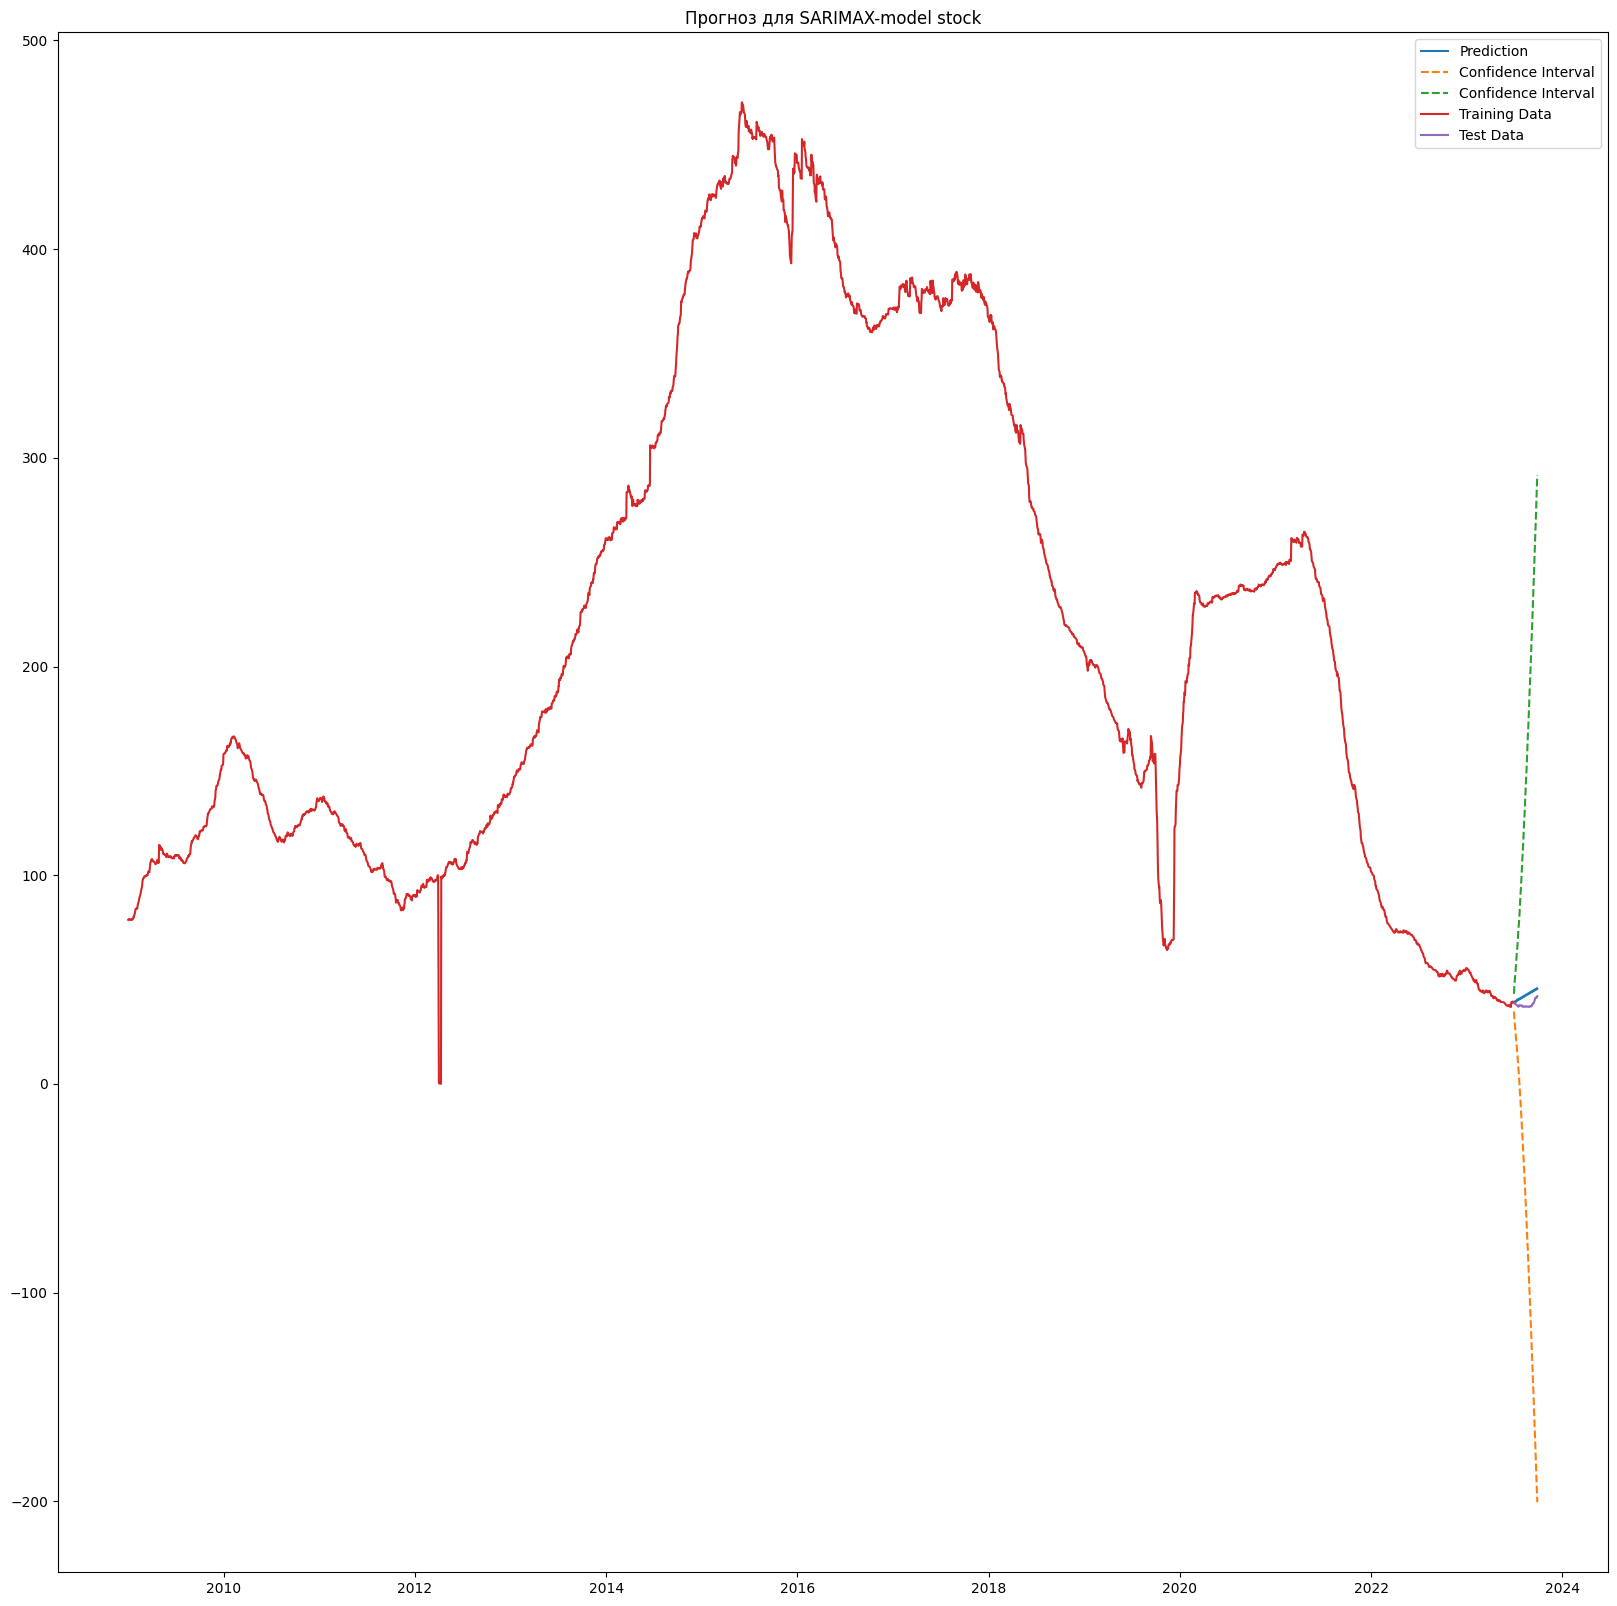

In [155]:
# Выведем график прогноза с доверительными интервалами
fig = plt.figure(figsize=(20, 20))
visualisation_prog(
    pred_sarimax_stock, conf_stock,
    train_stock, test_stock, name='SARIMAX-model stock'
)

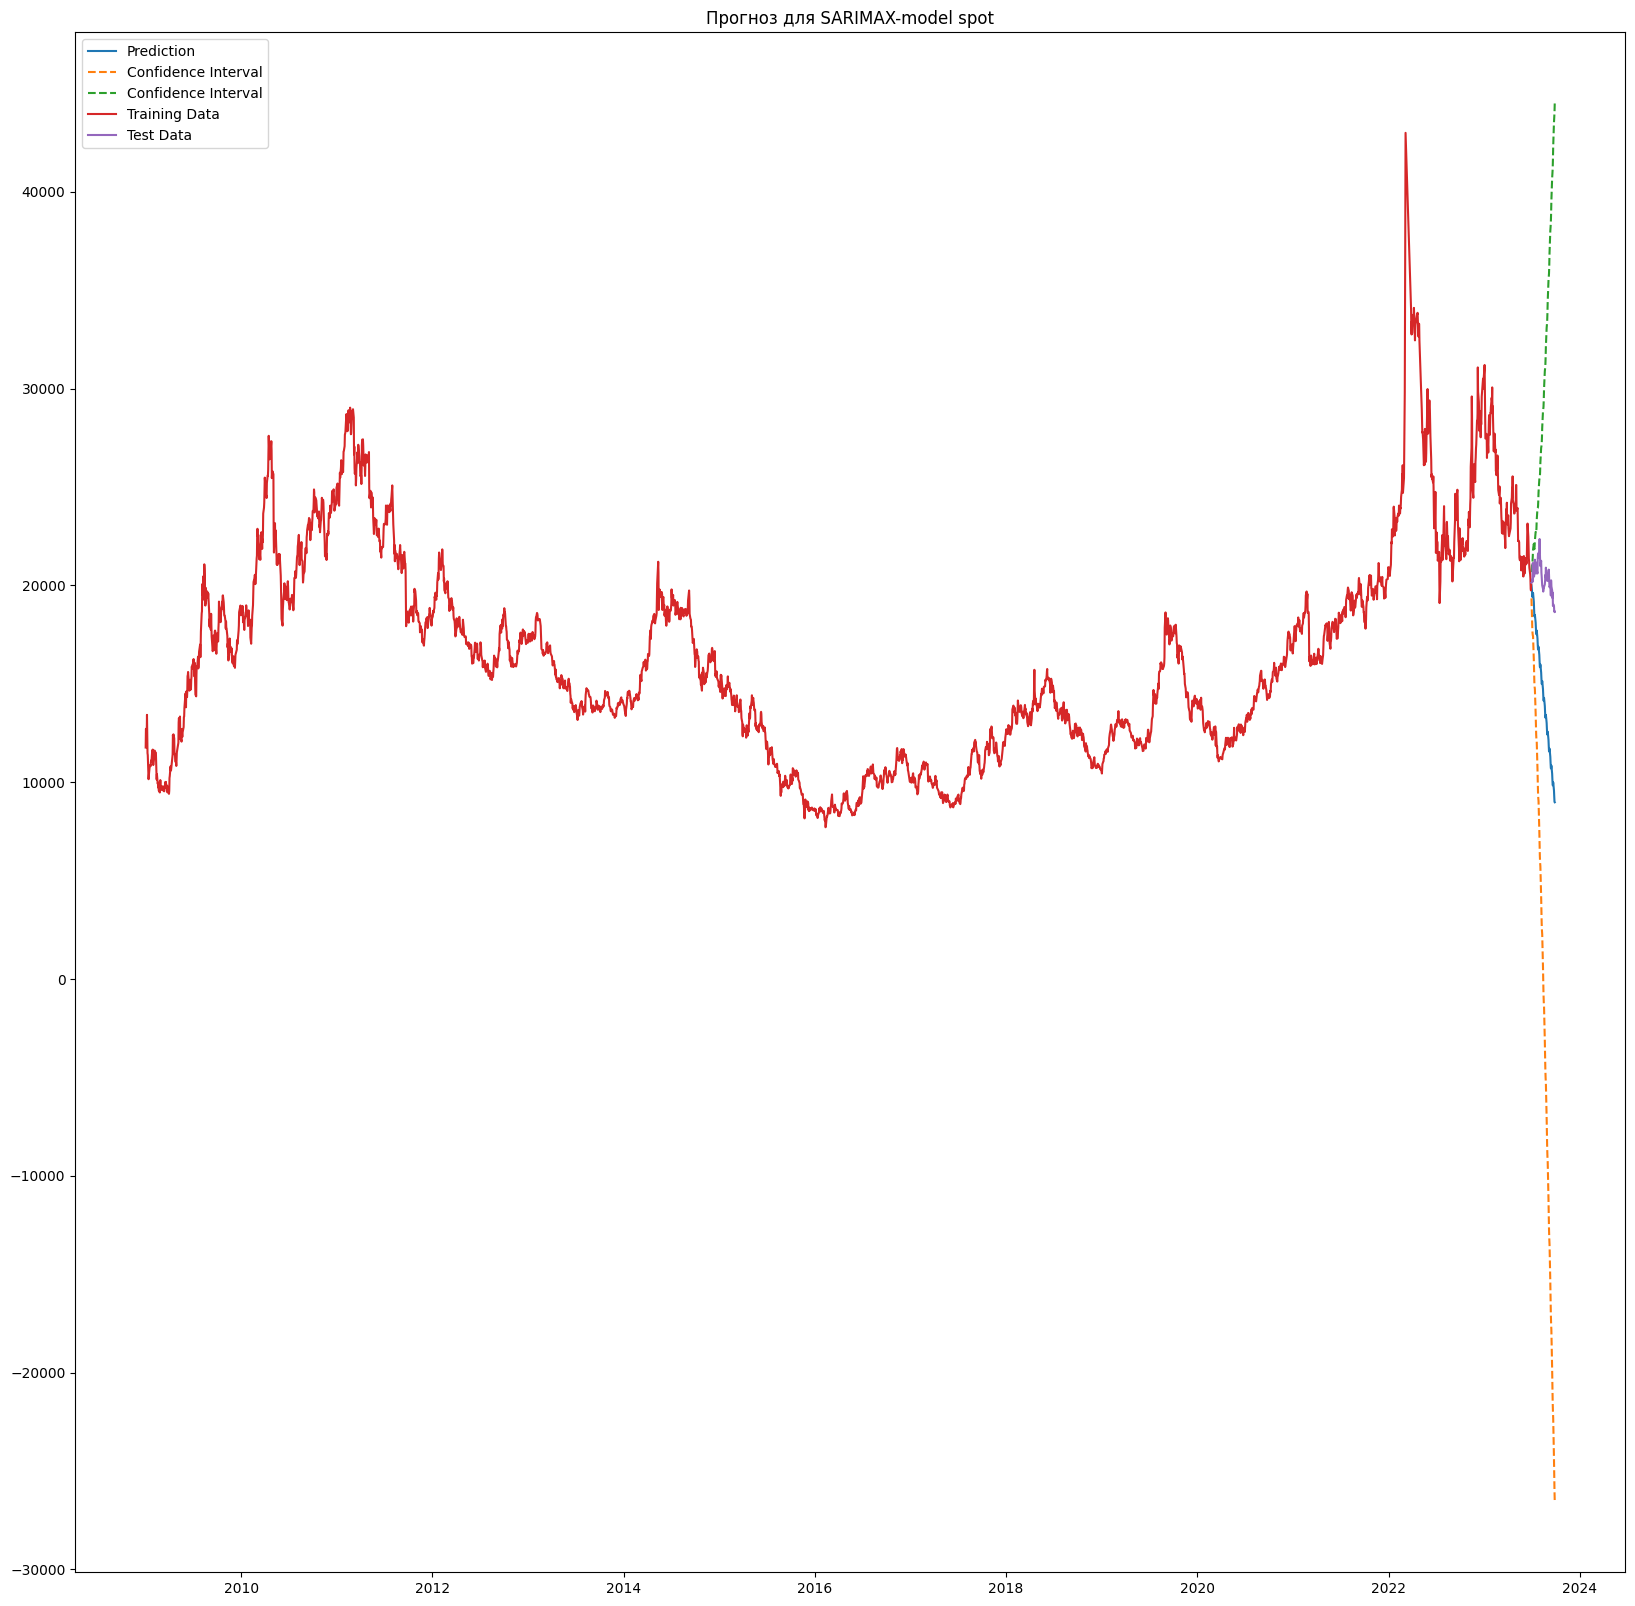

In [156]:
fig = plt.figure(figsize=(20, 20))
visualisation_prog(
    pred_sarimax_spot, conf_spot,
    train_spot, test_spot, name='SARIMAX-model spot'
)

> Вывод: SARIMAX показал наихудшие результаты, возможно причина заключается в интерполированных данных, либо же влиянии экзогенных факторов не учитываемых в данном анализе (напоминаю нам необходимо разработать легковесный бенчмарк для LME для расчета среднеквартальной цены)

---

### GARCH прогноз для гетероскедастичного ряда.

In [157]:
# Инициализируем модель
garch_stock = arch_model(
    train_stock, lags=1, vol='GARCH',
    p=1, q=1, rescale=True).fit()

garch_spot = arch_model(
    train_spot, lags=1, vol='GARCH',
    p=2, q=1, rescale=True).fit()

# Сделаем предсказание
pred_garch_stock = garch_stock.forecast(
    start=str(train_stock.index[-1]), horizon=90)
pred_garch_spot = garch_spot.forecast(
    start=str(train_spot.index[-1]), horizon=90)

forecast_values = pred_garch_spot.mean.values[-1, :]
for i in range(len(test_spot)):
    print(
        f"Фактическое значение: {test_spot[i]}, Прогнозное значение: {forecast_values[i]}")

Iteration:      1,   Func. Count:      6,   Neg. LLF: 2451759786.271046
Iteration:      2,   Func. Count:     12,   Neg. LLF: 1625097047536.9668
Iteration:      3,   Func. Count:     19,   Neg. LLF: 24297.53625329535
Iteration:      4,   Func. Count:     25,   Neg. LLF: 17739.238317538562
Iteration:      5,   Func. Count:     30,   Neg. LLF: 20133.83948501901
Iteration:      6,   Func. Count:     42,   Neg. LLF: 17439.158101851965
Iteration:      7,   Func. Count:     47,   Neg. LLF: 17486.984805960485
Iteration:      8,   Func. Count:     58,   Neg. LLF: 17718.83157538994
Iteration:      9,   Func. Count:     64,   Neg. LLF: 17419.169675321908
Iteration:     10,   Func. Count:     69,   Neg. LLF: 17466.438751627524
Iteration:     11,   Func. Count:     75,   Neg. LLF: 17456.593344340545
Iteration:     12,   Func. Count:     81,   Neg. LLF: 17424.28892037283
Iteration:     13,   Func. Count:     87,   Neg. LLF: 17413.75193237255
Iteration:     14,   Func. Count:     92,   Neg. LLF: 174

> В будущем нам пригодится SARIMAX, хоть сама модель и не подошла, но мы будем прогнозировать дисперсию и накладывать на результаты прогноза спота и запасов.

---

### Перед тем как перейти кследующей части, произведем небольшую манипуляцию с данными для проверки модели с включением экзогенных факторов (для нас это фьючерсы).

In [158]:
# Посмотрим на картины прогнозов для моделей показавших лучший результат
# с использованием авторегрессии
display(pred_ar_stock.tail(15), pred_arima_stock.tail(15))

2023-09-14    39.050039
2023-09-15    38.945842
2023-09-16    38.879533
2023-09-17    38.813223
2023-09-18    38.746914
2023-09-19    38.794923
2023-09-20    39.062608
2023-09-21    39.058731
2023-09-22    38.954533
2023-09-23    38.888224
2023-09-24    38.821914
2023-09-25    38.755604
2023-09-26    38.803613
2023-09-27    39.071297
2023-09-28    39.067420
Freq: D, dtype: float64

2023-09-14    39.516942
2023-09-15    39.525701
2023-09-16    39.534459
2023-09-17    39.543216
2023-09-18    39.551973
2023-09-19    39.560730
2023-09-20    39.569486
2023-09-21    39.578242
2023-09-22    39.586998
2023-09-23    39.595752
2023-09-24    39.604507
2023-09-25    39.613261
2023-09-26    39.622015
2023-09-27    39.630768
2023-09-28    39.639521
Freq: D, dtype: float64

In [159]:
# Выбираем модель для прогноза остатков, тут стоит отметить почему
# выбор пал на базовую модель, дело в том, что различие в метриках
# было не значительно, но сама картина прогнозных запасов выглядит
# реалистичнее ()
best_ts = pred_ar_stock

In [160]:
# Объединим тренировочную выборку по запасам с предсказанием в единый вектор
stock_column = pd.concat([train_stock, best_ts])
stock_column.tail(10)

2023-09-19    38.794923
2023-09-20    39.062608
2023-09-21    39.058731
2023-09-22    38.954533
2023-09-23    38.888224
2023-09-24    38.821914
2023-09-25    38.755604
2023-09-26    38.803613
2023-09-27    39.071297
2023-09-28    39.067420
dtype: float64

In [161]:
# Создадим новую рабочую выборку, она нам понадобится и на этом этапе и для дальнейшего исследования.
working_data_new = pd.concat(
    [working_data[[working_data.columns.to_list()[0], working_data.columns.to_list()[
        1]]], stock_column],
    axis=1).rename(columns={0: working_data.columns.to_list()[2]})

display(working_data.head(), working_data.tail())

,LME Nickel Cash-Settlement,LME Nickel 3-month,LME Nickel stock
date,,,
2009-01-01,11760.000000,15425.000000,78.606
2009-01-02,12710.000000,15118.333333,78.822
2009-01-03,12608.333333,14811.666667,78.854
2009-01-04,12506.666667,14505.000000,78.886
2009-01-05,12405.000000,14255.000000,78.918


,LME Nickel Cash-Settlement,LME Nickel 3-month,LME Nickel stock
date,,,
2023-09-24,18983.333333,20800.0,41.292
2023-09-25,18950.000000,20525.0,41.292
2023-09-26,18675.000000,20055.0,41.328
2023-09-27,18700.000000,20000.0,41.628
2023-09-28,18650.000000,20275.0,41.982


In [162]:
# Сформируем трейн/тест для общего случая
train = working_data_new[:len(train_spot)]
test = working_data_new[-len(test_spot):]

In [163]:
# Тренировочная эндогенная
endog_train = train.iloc[:, 0]
# Небольшой пердолинг для экзогенных
exog_train = train.iloc[:, 1:]
exog_test = test.iloc[:, 1:]
# exog_train = pd.concat([exog_train, exog_test], axis=0)

# Тестовая выборка
endog_test = test.iloc[:, 0]

# Горизонт планирования
start = str(endog_test.index.min())
end = str(endog_test.index.max())

In [164]:
# Инициализируем модель, порядок p,d,q возьмем из предлагаемых pdarima
arimax_model_spot = ARIMA(endog_train, exog=exog_train, order=order_spot).fit()

In [165]:
# Спрогнозируем
pred_arimax_spot = arimax_model_spot.predict(
    start=start, end=end, exog=exog_test)

In [166]:
log_metrics_spot(metrics_calculation(
    pred_arimax_spot, endog_test, name='ARIMAX-spot'))

RMSE для ARIMAX-spot: 744.864
MAE для ARIMAX-spot: 584.449
MAPE для ARIMAX-spot: 2.9000000000000004%




> Хуже чем baseline.

----

### Попробуем методы МО в контексте прогноза запасов

In [167]:
# Реинициализируем выборку
working_data_ml = working_data.reset_index()

working_data_ml = working_data_ml.drop(
    columns=working_data_ml.columns.to_list()[1])

working_data_ml['date'] = working_data_ml['date'].apply(date_format_reverse)

# Сформируем трейн/тест для общего случая
train_ml = working_data_ml[:len(train_spot)]
test_ml = working_data_ml[-len(test_spot):]

# Разобьем на обучающую/тестовую подвыборки
X_train_ml = train_ml.iloc[:, :2]
y_train_ml = train_ml.iloc[:, 2]

X_test_ml = test_ml.iloc[:, :2]
y_test_ml = test_ml.iloc[:, 2]

---

#### Linear Regression

In [168]:
# Используем оптимальные параметры, и сформируем прогноз с последующим логированием
lr_model_ml = LinearRegression(
    n_jobs=-1
)

lr_model_ml.fit(X_train_ml, y_train_ml)

pred_lr_model_ml = lr_model_ml.predict(X_test_ml)
pred_lr_model_ml = pd.Series(pred_lr_model_ml, index=test.index)

log_metrics_stock(metrics_calculation(
    y_test_ml, pred_lr_model_ml, name='LR-model'))

RMSE для LR-model: 105.087
MAE для LR-model: 103.024
MAPE для LR-model: 271.0%




> Хуже baseline.

---

#### Decision Tree regressor for stock

In [169]:
param_grid = {
    'min_samples_leaf': [2, 3, 4, 5, 6],
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 5, 7, 10]
}

scoring = [
    'neg_mean_absolute_percentage_error',
    'neg_mean_absolute_error',
    'neg_root_mean_squared_error'
]

grid_search_dt_ml = GridSearchCV(
    estimator=DecisionTreeRegressor(
        random_state=42
    ),
    param_grid=param_grid,
    cv=5,
    scoring=scoring,
    refit='neg_mean_absolute_error',
    n_jobs=-1
)
grid_search_dt_ml.fit(X_train_ml, y_train_ml)
grid_search_dt_ml.best_params_

# Modeling
dt_model = DecisionTreeRegressor(
    **grid_search_dt_ml.best_params_,
    random_state=42
)
dt_model.fit(X_train_ml, y_train_ml)

pred_dt_spot_ml = dt_model.predict(X_test_ml)
pred_dt_spot_ml = pd.Series(pred_dt_spot_ml, index=test.index)

log_metrics_stock(metrics_calculation(
    y_test_ml, pred_dt_spot_ml, name='DT-model'))

RMSE для DT-model: 1.388
MAE для DT-model: 1.164
MAPE для DT-model: 3.0%




> Незначительно лучше baseline.

---

#### RandomForestRegressor для stock.

In [170]:
# Подберем оптимальные параметры через GridSearch с кроссвалидацией на 5 фолдах
scoring = [
    'neg_mean_absolute_percentage_error',
    'neg_mean_absolute_error',
    'neg_root_mean_squared_error'
]

param_grid = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 5, 7, 10]
}

grid_search_rfr_ml = GridSearchCV(
    estimator=RandomForestRegressor(
        random_state=42,
        n_jobs=-1
    ),
    param_grid=param_grid,
    cv=5,
    scoring=scoring,
    refit='neg_mean_absolute_error',
    n_jobs=-1
)
grid_search_rfr_ml.fit(X_train_ml, y_train_ml)
grid_search_rfr_ml.best_params_

# Modelling
rfr_model = RandomForestRegressor(
    **grid_search_rfr_ml.best_params_,
    random_state=42,
)

rfr_model.fit(X_train_ml, y_train_ml)

pred_rfr_model_ml = rfr_model.predict(X_test_ml)
pred_rfr_model_ml = pd.Series(pred_rfr_model_ml, index=test.index)

log_metrics_stock(metrics_calculation(
    y_test_ml, pred_rfr_model_ml, name='RFR-model'))

RMSE для RFR-model: 1.374
MAE для RFR-model: 1.131
MAPE для RFR-model: 2.9000000000000004%




> Хуже baseline.

----

### Gradient_boost stock

In [171]:
param_grid = {
    'learning_rate': [0.1, 0.2, 0.3, 0.4, 0.5],
    'n_estimators': [100, 200, 300],
    'min_samples_split': [2, 5, 7, 10],
    'min_samples_leaf': [1, 2, 3, 4, 5]
}

grid_search_gbr_ml = GridSearchCV(
    estimator=GradientBoostingRegressor(
        random_state=42),
    param_grid=param_grid,
    cv=5,
    scoring=scoring,
    refit='neg_mean_absolute_error',
    n_jobs=-1
)

grid_search_gbr_ml.fit(X_train_ml, y_train_ml)
grid_search_gbr_ml.best_params_

# Modelling
gbr_model_ml = GradientBoostingRegressor(
    **grid_search_gbr_ml.best_params_,
    random_state=42,
)

gbr_model_ml.fit(X_train_ml, y_train_ml)

pred_gbr_model_ml = gbr_model_ml.predict(X_test_ml)
pred_gbr_model_ml = pd.Series(pred_gbr_model_ml, test.index)

log_metrics_stock(metrics_calculation(
    y_test_ml, pred_gbr_model_ml, name='GBR-model_full'))

RMSE для GBR-model_full: 1.877
MAE для GBR-model_full: 1.64
MAPE для GBR-model_full: 4.3999999999999995%




> Хуже baseline.

---

### Stacking

In [172]:
# Создаем экземпляры моделей
linear_regression_model = LinearRegression()

decsion_tree_model = DecisionTreeRegressor(
    **grid_search_dt_ml.best_params_,
    random_state=42
)

random_forest_model = RandomForestRegressor(
    **grid_search_rfr_ml.best_params_,
    random_state=42,
)

gbr_model = GradientBoostingRegressor(
    **grid_search_gbr_ml.best_params_,
    random_state=42,
)


# Определяем базовые модели для стекинга
base_models = [
    ('LR-model', linear_regression_model), ('RandomForest', random_forest_model),
    ('Decision Tree', decsion_tree_model), ('GradientBoosting', gbr_model)]

# Определяем модель-мета регрессора
meta_model = LinearRegression()

# Создаем стекинг регрессора
stacking_regressor_ml = StackingRegressor(
    estimators=base_models, final_estimator=meta_model)

# Обучаем стекинг регрессора
stacking_regressor_ml.fit(X_train_ml, y_train_ml)

# Получаем предсказания
predictions_ml = stacking_regressor_ml.predict(X_test_ml)

log_metrics_stock(metrics_calculation(
    y_test_ml, predictions_ml, name='Stacking'))

RMSE для Stacking: 9.661
MAE для Stacking: 9.429
MAPE для Stacking: 24.9%




> Хуже baseline.

---

### Посмотрим на результаты моделирования запасов

In [173]:
pd.read_csv('./data/errors/stock_nickel.csv').sort_values(by='mae')

,date,model_name,rmse,mae,mape
6,2023-09-26 00:00:00,RFR-model,1.207,0.992,2.6
15,2023-09-27 00:00:00,RFR-model,1.256,1.035,2.7
5,2023-09-26 00:00:00,DT-model,1.244,1.056,2.8
24,2023-09-28 00:00:00,RFR-model,1.313,1.085,2.8
14,2023-09-27 00:00:00,DT-model,1.286,1.088,2.8
23,2023-09-28 00:00:00,DT-model,1.333,1.125,2.9
33,2023-09-29 00:00:00,RFR-model,1.374,1.131,2.9
32,2023-09-29 00:00:00,DT-model,1.388,1.164,3.0
18,2023-09-28 00:00:00,AR-baseline-stock,1.514,1.373,3.6
27,2023-09-29 00:00:00,AR-baseline-stock,1.573,1.440,3.8


> Вывод: Несмотря на небольшое превосходство дерева решений, был принят выбор в сторону AR-baseline в виду того, что:
> 1. Запасы имеют низкую корреляцию с целевой переменной, а следовательно точность их прогнозирования не значительно повлияет на финальный результат.
> 2. При моделировании запасов через дерево, мы опираемся на факторы, которые (spoiler) в последствии будут участвовать в прогнозах цен, что может привнести шум в прогноз.

---

## Часть 2.

#### В данной части мы возьмем модель предсказашую наилучший результат (на рассматриваемых метриках) для остатках запасов, затем используем вектор предсказания как фиты для моделей линейной регрессии, сравним с тестовой выборкой и оценим результат с лучшим результатом для прогноза спотовой цены полученного с помощью анализа временных рядов.

In [174]:
exp_train = train.reset_index(names='date')
exp_test = test.reset_index(names='date')

exp_train['date'] = exp_train['date'].apply(date_format_reverse)
exp_test['date'] = exp_test['date'].apply(date_format_reverse)

In [175]:
# Сформируем трейн/тест для спота
X_train = exp_train.drop(exp_train.columns.tolist()[1], axis=1)
y_train = exp_train[exp_train.columns.tolist()[1]]

X_test = exp_test.drop(exp_test.columns.tolist()[1], axis=1)
y_test = exp_test[exp_test.columns.tolist()[1]]

---

#### Linear Regression

In [176]:
# Используем оптимальные параметры, и сформируем прогноз с последующим логированием
lr_model = LinearRegression(
    n_jobs=-1
)

lr_model.fit(X_train, y_train)

pred_lr_model = lr_model.predict(X_test)
pred_lr_model = pd.Series(pred_lr_model, index=test.index)

log_metrics_spot(metrics_calculation(y_test, pred_lr_model, name='LR-model'))

RMSE для LR-model: 2576.554
MAE для LR-model: 2501.437
MAPE для LR-model: 12.3%




> Хуже baseline.

---

#### Decision Tree regressor

In [177]:
param_grid = {
    'min_samples_leaf': [2, 3, 4, 5, 6],
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 5, 7, 10]
}

scoring = [
    'neg_mean_absolute_percentage_error',
    'neg_mean_absolute_error',
    'neg_root_mean_squared_error'
]

grid_search_dt = GridSearchCV(
    estimator=DecisionTreeRegressor(
        random_state=42
    ),
    param_grid=param_grid,
    cv=5,
    scoring=scoring,
    refit='neg_mean_absolute_error',
    n_jobs=-1
)
grid_search_dt.fit(X_train, y_train)
grid_search_dt.best_params_

{'max_depth': 3, 'min_samples_leaf': 2, 'min_samples_split': 2}

In [178]:
dt_model = DecisionTreeRegressor(
    **grid_search_dt.best_params_,
    random_state=42
)

# Законсервируем модель на будущее
with open('./data/decision_tree_nk.pkl', 'wb') as input:
    pickle.dump(dt_model, input)

dt_model.fit(X_train, y_train)

pred_dt_spot = dt_model.predict(X_test)
pred_dt_spot = pd.Series(pred_dt_spot, index=test.index)
log_metrics_spot(metrics_calculation(y_test, pred_dt_spot, name='DT-model'))

RMSE для DT-model: 3702.905
MAE для DT-model: 3627.519
MAPE для DT-model: 18.0%




> Хуже baseline, но лучшая из представленных ниже.

---

#### Decision Tree regressor (only futures)

In [179]:
param_grid = {
    'min_samples_leaf': [2, 3, 4, 5, 6],
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 5, 7, 10]
}

scoring = [
    'neg_mean_absolute_percentage_error',
    'neg_mean_absolute_error',
    'neg_root_mean_squared_error'
]

grid_search_dt_s = GridSearchCV(
    estimator=DecisionTreeRegressor(
        random_state=42
    ),
    param_grid=param_grid,
    cv=5,
    scoring=scoring,
    refit='neg_mean_absolute_error',
    n_jobs=-1
)
grid_search_dt_s.fit(X_train.iloc[:, :-1], y_train)
grid_search_dt_s.best_params_

{'max_depth': 3, 'min_samples_leaf': 2, 'min_samples_split': 2}

In [180]:
dt_model_s = DecisionTreeRegressor(
    **grid_search_dt_s.best_params_,
    random_state=42
)
dt_model_s.fit(X_train.iloc[:, :-1], y_train)

pred_dt_spot_s = dt_model_s.predict(X_test.iloc[:, :-1])
pred_dt_spot_s = pd.Series(pred_dt_spot_s, index=test.index)
log_metrics_spot(metrics_calculation(
    y_test, pred_dt_spot_s, name='DT_simple-model'))

RMSE для DT_simple-model: 3702.905
MAE для DT_simple-model: 3627.519
MAPE для DT_simple-model: 18.0%




> Хуже baseline.

---

#### RandomForestRegressor для spot-price на основе только фючерсов.

In [181]:
# Подберем оптимальные параметры через GridSearch с кроссвалидацией на 5 фолдах
scoring = [
    'neg_mean_absolute_percentage_error',
    'neg_mean_absolute_error',
    'neg_root_mean_squared_error'
]

param_grid = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 5, 7, 10]
}

grid_search_srfr = GridSearchCV(
    estimator=RandomForestRegressor(
        random_state=42,
        n_jobs=-1
    ),
    param_grid=param_grid,
    cv=5,
    scoring=scoring,
    refit='neg_mean_absolute_error',
    n_jobs=-1
)
grid_search_srfr.fit(X_train.iloc[:, :2], y_train)
grid_search_srfr.best_params_

{'max_depth': 3, 'min_samples_split': 5, 'n_estimators': 500}

In [182]:
# Используем оптимальные параметры, и сформируем прогноз с последующим логированием
srfr_model = RandomForestRegressor(
    **grid_search_srfr.best_params_,
    random_state=42,
)

srfr_model.fit(X_train.iloc[:, :2], y_train)

pred_srfr_model = srfr_model.predict(X_test.iloc[:, :2])
pred_srfr_model = pd.Series(pred_srfr_model, index=test.index)

log_metrics_spot(metrics_calculation(
    y_test, pred_srfr_model, name='RFR-model_no_stock'))

RMSE для RFR-model_no_stock: 3735.831
MAE для RFR-model_no_stock: 3661.124
MAPE для RFR-model_no_stock: 18.099999999999998%




> Хуже baseline.

---

#### RandomForestRegressor для spot-price на основе спрогнозированных запасов.

In [183]:
# Подберем оптимальные параметры через GridSearch с кроссвалидацией на 5 фолдах
scoring = [
    'neg_mean_absolute_percentage_error',
    'neg_mean_absolute_error',
    'neg_root_mean_squared_error'
]

param_grid = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 5, 7, 10]
}

grid_search_rfr = GridSearchCV(
    estimator=RandomForestRegressor(
        random_state=42,
        n_jobs=-1
    ),
    param_grid=param_grid,
    cv=5,
    scoring=scoring,
    refit='neg_mean_absolute_error',
    n_jobs=-1
)
grid_search_rfr.fit(X_train, y_train)
grid_search_rfr.best_params_

{'max_depth': 7, 'min_samples_split': 10, 'n_estimators': 400}

In [184]:
# Используем оптимальные параметры, и сформируем прогноз с последующим логированием
rfr_model = RandomForestRegressor(
    **grid_search_rfr.best_params_,
    random_state=42,
)

rfr_model.fit(X_train, y_train)

pred_rfr_model = rfr_model.predict(X_test)
pred_rfr_model = pd.Series(pred_rfr_model, index=test.index)

log_metrics_spot(metrics_calculation(y_test, pred_rfr_model, name='RFR-model'))

RMSE для RFR-model: 1290.946
MAE для RFR-model: 1065.688
MAPE для RFR-model: 5.3%




> Хуже baseline.

----

### Gradient_boost stock + futures

In [185]:
param_grid = {
    'learning_rate': [0.1, 0.2, 0.3, 0.4, 0.5],
    'n_estimators': [100, 200, 300],
    'min_samples_split': [2, 5, 7, 10],
    'min_samples_leaf': [1, 2, 3, 4, 5]
}

grid_search_gbr = GridSearchCV(
    estimator=GradientBoostingRegressor(
        random_state=42),
    param_grid=param_grid,
    cv=5,
    scoring=scoring,
    refit='neg_mean_absolute_error',
    n_jobs=-1
)

grid_search_gbr.fit(X_train, y_train)
grid_search_gbr.best_params_

{'learning_rate': 0.5,
 'min_samples_leaf': 1,
 'min_samples_split': 10,
 'n_estimators': 300}

In [186]:
# Используем оптимальные параметры, и сформируем прогноз с последующим логированием
gbr_model = GradientBoostingRegressor(
    **grid_search_gbr.best_params_,
    random_state=42,
)

gbr_model.fit(X_train, y_train)

pred_gbr_model = gbr_model.predict(X_test)
pred_gbr_model = pd.Series(pred_gbr_model, test.index)

log_metrics_spot(metrics_calculation(
    y_test, pred_gbr_model, name='GBR-model_full'))

RMSE для GBR-model_full: 854.655
MAE для GBR-model_full: 664.237
MAPE для GBR-model_full: 3.2%




> Хуже baseline.

----

### Gradient_boost futures

In [187]:
param_grid = {
    'learning_rate': [0.1, 0.2, 0.3, 0.4, 0.5],
    'n_estimators': [100, 200, 300],
    'min_samples_split': [2, 5, 7, 10],
    'min_samples_leaf': [1, 2, 3, 4, 5]
}

grid_search_gbrs = GridSearchCV(
    estimator=GradientBoostingRegressor(
        random_state=42),
    param_grid=param_grid,
    cv=5,
    scoring=scoring,
    refit='neg_root_mean_squared_error',
    n_jobs=-1
)

grid_search_gbrs.fit(X_train.iloc[:, :2], y_train)
grid_search_gbrs.best_params_

{'learning_rate': 0.4,
 'min_samples_leaf': 4,
 'min_samples_split': 10,
 'n_estimators': 200}

In [188]:
# Используем оптимальные параметры, и сформируем прогноз с последующим логированием
gbrs_model = GradientBoostingRegressor(
    **grid_search_gbrs.best_params_,
    random_state=42,
)

gbrs_model.fit(X_train.iloc[:, :2], y_train)

pred_gbrs_model = gbrs_model.predict(X_test.iloc[:, :2])
pred_gbrs_model = pd.Series(pred_gbrs_model, index=test.index)

log_metrics_spot(metrics_calculation(
    y_test, pred_gbrs_model, name='GBR-model_futures'))

RMSE для GBR-model_futures: 869.225
MAE для GBR-model_futures: 679.45
MAPE для GBR-model_futures: 3.3000000000000003%




> Хуже baseline.

---

### Stacking

In [189]:
# Создаем экземпляры моделей
linear_regression_model = LinearRegression()

decsion_tree_model = DecisionTreeRegressor(
    **grid_search_dt.best_params_,
    random_state=42
)

random_forest_model = RandomForestRegressor(
    **grid_search_srfr.best_params_,
    random_state=42,
)

gbr_model = GradientBoostingRegressor(
    **grid_search_gbr.best_params_,
    random_state=42,
)


# Определяем базовые модели для стекинга
base_models = [
    ('LR-model', linear_regression_model), ('RandomForest', random_forest_model),
    ('Decision Tree', decsion_tree_model), ('GradientBoosting', gbr_model)]

# Определяем модель-мета регрессора
meta_model = LinearRegression()

# Создаем стекинг регрессора
stacking_regressor = StackingRegressor(
    estimators=base_models, final_estimator=meta_model)

# Обучаем стекинг регрессора
stacking_regressor.fit(X_train, y_train)

# Получаем предсказания
predictions = stacking_regressor.predict(X_test)

log_metrics_spot(metrics_calculation(y_test, predictions, name='Stacking'))

RMSE для Stacking: 1398.802
MAE для Stacking: 1293.151
MAPE для Stacking: 6.4%




> Хуже baseline.

---

## Часть 3.

### Проверка среднемесячных прогнозов

#### В реальных задачах нас интересуют средние показатели по металлу за месяц и квартал (более далекий горизонт планирования рассматривается лишь в конце года для формирования ТПФП), при том мы расчитываем реальные показатели на неинтерполированном ряду.

#### Первоначальное предположение складывалось из того, что мы понижаем точность прогноза в угоду простоте и мобильности, наша основная цель попасть в окно 250$ на спот при расчете среднемесячного и среднеквартального показателя.

#### В данном случае мы должны сравнить точность на среднемесячных для июля, августа и сентября (то что на данный момент есть), и соответсвенно для 3 квартала (с учетом не полного сентября)


In [190]:
# Посмотрим на модели показавшие наилучший результат по MAE
errors_spot = pd.read_csv('./data/errors/spot_nickel.csv', sep=',')
errors_spot.sort_values(by='mae').reset_index(drop=True)

,date,model_name,rmse,mae,mape
0,2023-09-26 00:00:00,AR-baseline-spot,695.110,538.610,2.6
1,2023-09-26 00:00:00,ARIMAX-spot,691.779,542.832,2.7
2,2023-09-26 00:00:00,ARIMA-spot,713.409,550.238,2.6
3,2023-09-29 00:00:00,ARIMAX-spot,744.864,584.449,2.9
4,2023-09-29 00:00:00,AR-baseline-spot,814.267,638.847,3.1
5,2023-09-29 00:00:00,GBR-model_full,854.655,664.237,3.2
6,2023-09-29 00:00:00,ARIMA-spot,836.797,667.092,3.2
7,2023-09-27 00:00:00,GBR-model_full,831.920,668.467,3.3
8,2023-09-29 00:00:00,GBR-model_futures,869.225,679.450,3.3
9,2023-09-28 00:00:00,GBR-model_futures,890.669,690.415,3.4


In [191]:
errors_stock = pd.read_csv('./data/errors/stock_nickel.csv', sep=',')
errors_stock.sort_values(by='mae').reset_index(drop=True)

,date,model_name,rmse,mae,mape
0,2023-09-26 00:00:00,RFR-model,1.207,0.992,2.6
1,2023-09-27 00:00:00,RFR-model,1.256,1.035,2.7
2,2023-09-26 00:00:00,DT-model,1.244,1.056,2.8
3,2023-09-28 00:00:00,RFR-model,1.313,1.085,2.8
4,2023-09-27 00:00:00,DT-model,1.286,1.088,2.8
5,2023-09-28 00:00:00,DT-model,1.333,1.125,2.9
6,2023-09-29 00:00:00,RFR-model,1.374,1.131,2.9
7,2023-09-29 00:00:00,DT-model,1.388,1.164,3.0
8,2023-09-28 00:00:00,AR-baseline-stock,1.514,1.373,3.6
9,2023-09-29 00:00:00,AR-baseline-stock,1.573,1.440,3.8


In [192]:
data = pd.read_csv('./data/nickel.csv',
                   parse_dates=['date'], index_col=['date'])
data.head()

,LME Nickel Cash-Settlement,LME Nickel 3-month,LME Nickel stock
date,,,
2023-09-28,18650.0,18875.0,41.982
2023-09-27,18700.0,18900.0,41.628
2023-09-26,18675.0,18990.0,41.328
2023-09-25,18950.0,19250.0,41.292
2023-09-22,19050.0,19350.0,41.292


In [193]:
# Расчитаем истинное среднее помесячно (горизонт - 3 месяца)
real_data_m = data.reset_index().groupby(
    pd.Grouper(key='date', freq='M')).mean()
real_data_m = real_data_m.tail(3)

real_data_m = real_data_m.reset_index()
columns = real_data_m.columns.to_list()

real_data_m['date'] = pd.to_datetime(real_data_m['date'])
real_data_m = real_data_m.rename(
    columns={columns[0]: 'Date', columns[1]: 'LME price_real'})
real_data_m = real_data_m.iloc[:, :2]
real_data_m

,Date,LME price_real
0,2023-07-31,20898.333333
1,2023-08-31,20497.727273
2,2023-09-30,19685.000000


In [194]:
pred = pred_dt_spot
final_raw = pd.concat([train_spot, pred]).reset_index()
final_raw = final_raw.rename(columns={'index': 'Date', 0: 'LME price_pred'})


final = final_raw[
    (final_raw['Date'].dt.month.isin([7, 8, 9]))
    & (final_raw['Date'].dt.year == 2023)
]

result_m = pd.DataFrame(final.groupby(
    pd.Grouper(key='Date', freq='M')).mean()).reset_index()

# Округлим до ближайшего десятка, да мы потеряем в точности, но в реальной работе округлние прогнозных цен
# производится до сотни, тем самым мы уже обходим по точности реализуемый подход
result_m = round(result_m, -1)
result_m

,Date,LME price_pred
0,2023-07-31,24010.0
1,2023-08-31,24010.0
2,2023-09-30,24010.0


In [195]:
result_table_m = pd.merge(left=result_m, right=real_data_m)
result_table_m['Delta'] = result_table_m.iloc[:, 1] - \
    result_table_m.iloc[:, 2]

result_table_m['Delta_%'] = (
    result_table_m['Delta']/result_table_m.iloc[:, 2])*100

display(result_table_m)
print(f'Mean delta: {round(result_table_m["Delta"].mean(),4)}')
print(f'Mean delta_%: {round(result_table_m["Delta_%"].mean(),4)}')

,Date,LME price_pred,LME price_real,Delta,Delta_%
0,2023-07-31,24010.0,20898.333333,3111.666667,14.889545
1,2023-08-31,24010.0,20497.727273,3512.272727,17.134937
2,2023-09-30,24010.0,19685.000000,4325.000000,21.971044


Mean delta: 3649.6465
Mean delta_%: 17.9985


#### Посмотрим на разброс по среднеквартальному показателю (используем модельный квартал)

In [196]:
# Расчитаем истинное среднее для квартала
real_data_q = data.reset_index()

real_data_q = real_data_q.rename(
    columns={columns[0]: 'Date', columns[1]: 'LME price_real'})

real_data_q['Date'] = pd.to_datetime(real_data_q['Date'])

real_data_q = real_data_q[
    (real_data_q['Date'].dt.year == 2023) &
    (real_data_q['Date'].dt.month.isin([7, 8, 9]))
]

real_data_q = real_data_q.iloc[:, :2]
quarter_real = round(real_data_q['LME price_real'].mean(), 4)
quarter_real

20373.254

In [197]:
# Среднее для прогнозного квартала
quarter_pred = round(final['LME price_pred'].mean(), -1)
quarter_pred

24010.0

In [198]:
# Определим дельту между реальным средним и прогнозным по кварталу
quarter_delta = quarter_pred - quarter_real
quarter_delta = round(quarter_delta, 4)
quarter_delta

3636.746

---
---
---

## Часть 4.

#### Воссоздадим модель и прикрутим к ней допфункционал, пока что это будет промежуточный этап перед моделью финального прогноза.

Начнем с самого начала для формирования основного алгоритма действий.
Но для начала опишем какой по итогу план действий был принят:

1. Произвести выгрузку данных из БД.

2. Произвести предобработку данных для последующей отправки на соответсвующий нод.

3. Спрогнозировать дисперсию для корректировки прогнозов по запасам и спотовой цене.

4. Применеть AutoReg (наш baseline) на запасы, для формирования фита Decision Tree Regressor для прогноза цены деревом.

5. Применеть AutoReg (наш baseline) на спот, для формирования прогноза, который будет усредняться с прогнозом дерева (для обеспечения стабильности, т.к. AutoReg имеет тенденцию к заваливанию).

6. Применить Decision Tree Regressor для прогноза цены деревом.

7. Сформировать итоговый прогноз.

8. Вывести итоговый прогноз с добавлением доверительных интервалов в аггрегирующую таблицу и график.

9. Пересобрать каждый этап в виде скрипта и сформировать на их основе микросервисную архитектуру.

P.S. Буду часто использовать английский, т.к. задолбался переключать раскладку.

Ниже представлена схема проекта со связями на нодах.

![Alt text](<data/project_architecture v4-2.png>)

---

#### 1. Data_reconstruction
>

In [228]:
# Инициализируем первичный датасет для авторегрессионного прогноза запасов
data = pd.read_csv(
    './data/nickel.csv',
    parse_dates=['date'], index_col=['date'])

data.replace(0, np.nan, inplace=True)
data.dropna(inplace=True, axis=0)

data = data.resample('d').interpolate(method='linear')
data.reset_index(inplace=True)

In [229]:
# Подготовим таблицу для сдвига фючерсов
data_prognosis = pd.DataFrame(columns=['date'])
start_date = str(data['date'].iloc[-1] + pd.DateOffset(days=1))
date_range = pd.date_range(start_date, periods=90, freq='D')
data_prognosis['date'] = date_range

# Объединим таблицы
data = pd.concat([data, data_prognosis])

# Отcортируем и вернем индексы
data = data.sort_values(by='date')

# Произведем сдвиг LME stock 3-month, представляющим своего рода фьючерс на медь
# (точнее представляет цену для операций сроком на 3 месяца.
#  Это означает, что цена отражает стоимость меди на рынке с учетом сроковых контрактов на 3 месяца.)
data.iloc[:, 2] = data.iloc[:, 2].shift(90)

# Обрежем нижние nan-ы, т.к. мы получили наши фьючерсы
data = data[~data.iloc[:, 2].isna()]

data.set_index('date', inplace=True)

display(data.head(), data.tail())

,LME Nickel Cash-Settlement,LME Nickel 3-month,LME Nickel stock
date,,,
2008-04-01,26250.000000,26725.0,47.122235
2008-04-02,26214.285714,28400.0,47.120622
2008-04-03,26178.571429,29825.0,47.119008
2008-04-04,26142.857143,29285.0,47.117395
2008-04-05,26107.142857,28745.0,47.115782


,LME Nickel Cash-Settlement,LME Nickel 3-month,LME Nickel stock
date,,,
2023-12-24,NaN,19250.0,NaN
2023-12-25,NaN,18990.0,NaN
2023-12-26,NaN,18900.0,NaN
2023-12-27,NaN,18875.0,NaN
2023-12-28,NaN,18825.0,NaN


-----
____

#### Data_reconstructor return

In [230]:
# Разделим датасет на две выборки:
# рабочую информацию (для трейн/тест) и часть
# для будущего прогноза неизвестного периода
split_param = (data.iloc[:, 0].isna()) & (data.iloc[:, 2].isna())
data_target = data[split_param]
working_data = data[~split_param]

# Теперь поделим рабочую выборку
train = working_data.iloc[:-90]
test = working_data.iloc[-90:]

#### Далее описаны связи с другими модулями

---

#### On GARCH Variance_pred for stock and spot

In [231]:
working_data.tail()

,LME Nickel Cash-Settlement,LME Nickel 3-month,LME Nickel stock
date,,,
2023-09-25,18950.0,20525.000000,41.292
2023-09-26,18675.0,20055.000000,41.328
2023-09-27,18700.0,20000.000000,41.628
2023-09-28,18650.0,20275.000000,41.982
2023-09-29,18510.0,20333.333333,42.228


----

#### On Stock_AR (on full real data)

In [232]:
working_data.tail()

,LME Nickel Cash-Settlement,LME Nickel 3-month,LME Nickel stock
date,,,
2023-09-25,18950.0,20525.000000,41.292
2023-09-26,18675.0,20055.000000,41.328
2023-09-27,18700.0,20000.000000,41.628
2023-09-28,18650.0,20275.000000,41.982
2023-09-29,18510.0,20333.333333,42.228


In [233]:
data_target.tail()

,LME Nickel Cash-Settlement,LME Nickel 3-month,LME Nickel stock
date,,,
2023-12-24,NaN,19250.0,NaN
2023-12-25,NaN,18990.0,NaN
2023-12-26,NaN,18900.0,NaN
2023-12-27,NaN,18875.0,NaN
2023-12-28,NaN,18825.0,NaN


---

#### On Spot_AR (on real data + target data)

In [234]:
working_data.tail()

,LME Nickel Cash-Settlement,LME Nickel 3-month,LME Nickel stock
date,,,
2023-09-25,18950.0,20525.000000,41.292
2023-09-26,18675.0,20055.000000,41.328
2023-09-27,18700.0,20000.000000,41.628
2023-09-28,18650.0,20275.000000,41.982
2023-09-29,18510.0,20333.333333,42.228


---

#### On prognosis

In [235]:
working_data.tail()

,LME Nickel Cash-Settlement,LME Nickel 3-month,LME Nickel stock
date,,,
2023-09-25,18950.0,20525.000000,41.292
2023-09-26,18675.0,20055.000000,41.328
2023-09-27,18700.0,20000.000000,41.628
2023-09-28,18650.0,20275.000000,41.982
2023-09-29,18510.0,20333.333333,42.228


----
----

#### GARCH Variance_pred for stock and spot
>

##### Stock

На нормальном распределении

In [236]:
# Инициируем рабочий ряд
returns_stock = working_data.iloc[:, -1]

# Начнем моделировать используя параметры из исследования
model_garch_stock = arch_model(
    returns_stock, vol='Garch', p=4, q=1, rescale=True).fit()

# Произведем прогноз с горизонотом равным 90 дней
forecast_garch_stock = model_garch_stock.forecast(horizon=90)

# Выделим спрогнозированную дисперсию
forecast_variance_stock = forecast_garch_stock.variance.values[-1]

# Генерация случайных значений с нулевым средним и прогнозируемой дисперсией
# corr_values_stock = np.random.normal(
#    loc=0, scale=np.sqrt(np.log(forecast_variance_stock)))
corr_values_stock = np.random.normal(
    loc=0, scale=np.sqrt(forecast_variance_stock))


corr_values_stock = pd.Series(corr_values_stock)

round(corr_values_stock, 3)
corr_values_stock

Iteration:      1,   Func. Count:      9,   Neg. LLF: 1428165720.3618424
Iteration:      2,   Func. Count:     18,   Neg. LLF: 28135.02155012662
Iteration:      3,   Func. Count:     28,   Neg. LLF: 19754.64749571732
Iteration:      4,   Func. Count:     37,   Neg. LLF: 18809.934987577777
Iteration:      5,   Func. Count:     45,   Neg. LLF: 3120341.9242194304
Iteration:      6,   Func. Count:     61,   Neg. LLF: 19028.559338952113
Iteration:      7,   Func. Count:     72,   Neg. LLF: 22743.00008493998
Iteration:      8,   Func. Count:     84,   Neg. LLF: 18410.148421328027
Iteration:      9,   Func. Count:     92,   Neg. LLF: 18409.99916042744
Iteration:     10,   Func. Count:    100,   Neg. LLF: 18408.335621650396
Iteration:     11,   Func. Count:    108,   Neg. LLF: 18408.15305485292
Iteration:     12,   Func. Count:    116,   Neg. LLF: 18408.970494290617
Iteration:     13,   Func. Count:    125,   Neg. LLF: 18407.942866918856
Iteration:     14,   Func. Count:    133,   Neg. LLF: 18

0    -5.137416
1    -4.941237
2     1.517786
3     6.003586
4    -6.528673
        ...   
85    3.646314
86    0.299644
87    3.973362
88    2.163392
89   -4.725455
Length: 90, dtype: float64

##### Spot

In [237]:
# Инициируем рабочий ряд
returns_spot = working_data.iloc[:, 0]

# Начнем моделировать используя параметры из исследования
model_garch_spot = arch_model(
    returns_spot, vol='Garch', p=2, q=1, rescale=True).fit()

# Произведем прогноз с горизонотом равным 90 дней
forecast_garch_spot = model_garch_spot.forecast(horizon=90)

# Выделим спрогнозированную дисперсию
forecast_variance_spot = forecast_garch_spot.variance.values[-1]

# Генерация случайных значений с нулевым средним и прогнозируемой дисперсией
corr_values_spot = np.random.normal(
    loc=0, scale=np.sqrt(forecast_variance_spot))

corr_values_spot = pd.Series(corr_values_spot)
round(corr_values_spot, 3)
corr_values_spot

Iteration:      1,   Func. Count:      7,   Neg. LLF: 185927.89139215945
Iteration:      2,   Func. Count:     14,   Neg. LLF: 35938.85959052196
Iteration:      3,   Func. Count:     21,   Neg. LLF: 27919.756998958266
Iteration:      4,   Func. Count:     28,   Neg. LLF: 27491.755118515626
Iteration:      5,   Func. Count:     34,   Neg. LLF: 27636.426889915914
Iteration:      6,   Func. Count:     41,   Neg. LLF: 33706.591163023404
Iteration:      7,   Func. Count:     48,   Neg. LLF: 27383.417369816376
Iteration:      8,   Func. Count:     55,   Neg. LLF: 30451.844323662277
Iteration:      9,   Func. Count:     62,   Neg. LLF: 33064.7666597762
Iteration:     10,   Func. Count:     69,   Neg. LLF: 33351.189586646404
Iteration:     11,   Func. Count:     76,   Neg. LLF: 27786.35524940666
Iteration:     12,   Func. Count:     83,   Neg. LLF: 28377.77172577974
Iteration:     13,   Func. Count:     90,   Neg. LLF: 27762.031554891477
Iteration:     14,   Func. Count:     97,   Neg. LLF: 27

0     18.592533
1     48.491205
2      1.375622
3    -40.576475
4     43.622166
        ...    
85    50.000480
86    33.688391
87   -13.167437
88    -5.732225
89   -59.054207
Length: 90, dtype: float64

---
---

#### On Stock_AR (on full real data)

In [238]:
display(corr_values_stock)

0    -5.137416
1    -4.941237
2     1.517786
3     6.003586
4    -6.528673
        ...   
85    3.646314
86    0.299644
87    3.973362
88    2.163392
89   -4.725455
Length: 90, dtype: float64

---

#### On Spot_DT (on real data)

In [239]:
display(corr_values_spot)

0     18.592533
1     48.491205
2      1.375622
3    -40.576475
4     43.622166
        ...    
85    50.000480
86    33.688391
87   -13.167437
88    -5.732225
89   -59.054207
Length: 90, dtype: float64

---
---

### Stock_AR (on full real data)

In [240]:
# Произведем прогноз моделью AutoReg для запасов
ar_model_real_stock = AutoReg(
    working_data.iloc[:, -1], lags=4, seasonal=True).fit()
pred_real_stock = ar_model_real_stock.predict(
    start=len(working_data), end=len(working_data)+89)

pred_real_stock += corr_values_stock.values

In [241]:
# Создадим копию таргета
forecast_dt = data_target.copy()

# И копию реальных данных
train_dt = working_data.copy()

# Занесем данные по запасам из предсказания
forecast_dt.iloc[:, 2] = pred_real_stock

# Cбросим индексы
train_dt.reset_index(inplace=True)
forecast_dt.reset_index(inplace=True)

# Сформируем датафрейм (train/forecast) для нашего боевого прогноза
columns = forecast_dt.columns.to_list()


def date_format_reverse(date):
    date = datetime.strptime(
        str(date),
        "%Y-%m-%d %H:%M:%S").timestamp()*1000
    return int(date)


train_dt.iloc[:, 0] = train_dt.iloc[:, 0].apply(date_format_reverse)
forecast_dt.iloc[:, 0] = forecast_dt.iloc[:, 0].apply(date_format_reverse)

---

#### On Spot_DT (on stock prognosis + full real data)

In [242]:
display(train_dt.head())

,date,LME Nickel Cash-Settlement,LME Nickel 3-month,LME Nickel stock
0,1206986400000,26250.000000,26725.0,47.122235
1,1207072800000,26214.285714,28400.0,47.120622
2,1207159200000,26178.571429,29825.0,47.119008
3,1207245600000,26142.857143,29285.0,47.117395
4,1207332000000,26107.142857,28745.0,47.115782


In [243]:
display(forecast_dt.head())

,date,LME Nickel Cash-Settlement,LME Nickel 3-month,LME Nickel stock
0,1696014000000,NaN,20391.666667,37.144015
1,1696100400000,NaN,20450.000000,37.352064
2,1696186800000,NaN,20525.000000,43.796425
3,1696273200000,NaN,20405.000000,48.366464
4,1696359600000,NaN,21260.000000,36.121279


---
---

### Spot_AR (on real data + target data)

In [244]:
# Произведем прогноз моделью AutoReg для спотовой цены
ar_model_real_spot = AutoReg(
    working_data.iloc[:, 1], lags=2, seasonal=True).fit()
pred_real_spot = ar_model_real_spot.predict(
    start=len(working_data), end=len(working_data)+89)

result_ar = pd.DataFrame(
    pred_real_spot,
    columns=['AutoReg_prognosis'])

---

#### On prognosis adjustment

In [245]:
display(result_ar)

,AutoReg_prognosis
2023-09-30,20337.040036
2023-10-01,20330.589069
2023-10-02,20323.707124
2023-10-03,20304.290234
2023-10-04,20293.249267
...,...
2023-12-24,19506.799359
2023-12-25,19501.647756
2023-12-26,19484.304297
2023-12-27,19475.395671


---
---

### Spot_DT (on stock prognosis + full real data)

In [246]:
X_train = train_dt.drop(columns[1], axis=1)
y_train = train_dt[columns[1]]

X_test = forecast_dt.drop(columns[1], axis=1)

In [247]:
# Распиклим модель с оптимальными параметрами 
# просто что бы показать что умею солить модели
with open('./data/decision_tree_nk.pkl', 'rb') as input:
    dt_pkl_model = pickle.load(input)

In [248]:
# Произведем моделирование
dt_pkl_model.fit(X_train, y_train)

pred_dt_final = dt_pkl_model.predict(X_test) + corr_values_spot.values
pred_dt_final = pd.Series(pred_dt_final)

In [249]:
result_dt = forecast_dt.copy()
result_dt.iloc[:, 1] = pred_dt_final


def date_format(date_raw):
    timestamp = date_raw / 1000
    date = datetime.fromtimestamp(timestamp)
    formatted_date = date.strftime("%Y-%m-%d %H:%M:%S")
    return formatted_date


result_dt.iloc[:, 0] = result_dt.iloc[:, 0].apply(date_format)

result_dt.iloc[:, 0] = pd.to_datetime(result_dt.iloc[:, 0])

result_dt.set_index(result_dt.iloc[:, 0], inplace=True)

result_dt = pd.DataFrame(result_dt.iloc[:, 1])

result_dt = result_dt.rename(
    columns={result_dt.columns.tolist()[0]: 'DecisionTree_prognosis'})

---
---

#### On prognosis

In [250]:
display(result_dt)

,DecisionTree_prognosis
date,
2023-09-30,23319.304559
2023-10-01,23349.203230
2023-10-02,23302.087648
2023-10-03,23260.135550
2023-10-04,23344.334191
...,...
2023-12-24,23350.712505
2023-12-25,23334.400416
2023-12-26,23287.544588


---
---

### Prognosis

In [251]:
adj_df = pd.concat([result_ar, result_dt], axis=1)
adj_df['Final_prognosis'] = np.mean(
    [adj_df['AutoReg_prognosis'], adj_df['DecisionTree_prognosis']], axis=0)
adj_df.dropna(inplace=True)

prognosis_product_day = pd.concat(
    [working_data.iloc[:, 0], adj_df['Final_prognosis']])

display(prognosis_product_day.tail(90))

2023-09-30    21828.172297
2023-10-01    21839.896149
2023-10-02    21812.897386
2023-10-03    21782.212892
2023-10-04    21818.791729
                  ...     
2023-12-24    21428.755932
2023-12-25    21418.024086
2023-12-26    21385.924443
2023-12-27    21385.187736
2023-12-28    21353.669127
Length: 90, dtype: float64

---

### Confidence interval for months

Значение 1.96 используется для расчета доверительного интервала на основе нормального распределения с уровнем доверия 95%. 

В статистике и теории вероятностей, распределение Стьюдента (t-распределение) используется для расчета доверительных интервалов на основе небольших выборок. Однако, при достаточно большом размере выборки (обычно более 30 наблюдений), t-распределение асимптотически приближается к нормальному распределению. 

Для нормального распределения с уровнем доверия 95%, значение 1.96 соответствует двум стандартным отклонениям от среднего значения в каждую сторону (1.96 * стандартное отклонение). Использование этого значения позволяет получить доверительный интервал, который содержит примерно 95% значений из выборки приближенно к нормальному распределению.

In [252]:
prognosis_product_month = pd.DataFrame(prognosis_product_day.groupby(
    pd.Grouper(freq='M')).mean())

prognosis_product_month = prognosis_product_month.rename(columns={0: 'mean'})

prognosis_product_month = prognosis_product_month.iloc[-4:, :]

prognosis_product_month['std'] = pd.DataFrame(prognosis_product_day.groupby(
    pd.Grouper(freq='M')).std())

prognosis_product_month['num_days'] = pd.DataFrame(prognosis_product_day.groupby(
    pd.Grouper(freq='M')).count())

prognosis_product_month['min'] = prognosis_product_month['mean'] - 1.96 * \
    (prognosis_product_month['std'] /
     np.sqrt(prognosis_product_month['num_days']))

prognosis_product_month['max'] = prognosis_product_month['mean'] + 1.96 * \
    (prognosis_product_month['std'] /
     np.sqrt(prognosis_product_month['num_days']))

prognosis_product_month = prognosis_product_month.drop(
    ['std', 'num_days'], axis=1)
prognosis_product_month

,mean,min,max
2023-09-30,19757.105743,19481.491126,20032.720361
2023-10-31,21742.564011,21723.700428,21761.427594
2023-11-30,21682.996890,21472.959762,21893.034018
2023-12-31,21449.760001,21432.612571,21466.907432


---

### Confidence interval for quarer

In [253]:
prognosis_product_q = prognosis_product_day

prognosis_product_q = pd.DataFrame(
    prognosis_product_q.groupby(pd.Grouper(freq='Q')).mean())

prognosis_product_q = prognosis_product_q.rename(columns={0: 'mean'})

prognosis_product_q['std'] = pd.DataFrame(
    prognosis_product_day.groupby(pd.Grouper(freq='Q')).std())

prognosis_product_q['num_days'] = pd.DataFrame(
    prognosis_product_day.groupby(pd.Grouper(freq='Q')).count())

prognosis_product_q['min'] = prognosis_product_q['mean'] - 1.96 * \
    (prognosis_product_q['std'] /
     np.sqrt(prognosis_product_q['num_days']))

prognosis_product_q['max'] = prognosis_product_q['mean'] + 1.96 * \
    (prognosis_product_q['std'] /
     np.sqrt(prognosis_product_q['num_days']))

prognosis_product_q = prognosis_product_q.drop(columns=['std', 'num_days'])

prognosis_product_q = prognosis_product_q.iloc[-1:, :]

prognosis_product_q = prognosis_product_q.rename(
    index={prognosis_product_q.index[0]: 'Quarter'})

---

#### Final results

In [254]:
result_df = pd.concat([prognosis_product_month, prognosis_product_q], axis=0)
result_df = result_df.round()
result_df

,mean,min,max
2023-09-30 00:00:00,19757.0,19481.0,20033.0
2023-10-31 00:00:00,21743.0,21724.0,21761.0
2023-11-30 00:00:00,21683.0,21473.0,21893.0
2023-12-31 00:00:00,21450.0,21433.0,21467.0
Quarter,21630.0,21555.0,21706.0


---
---

### Line plot

<Axes: xlabel='date', ylabel='LME Nickel Cash-Settlement'>

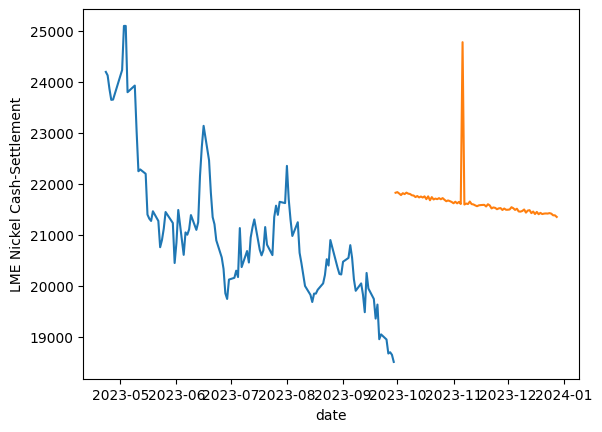

In [255]:
sns.lineplot(working_data.iloc[5500:, 0])
sns.lineplot(adj_df['Final_prognosis'])


---
---